In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv('/content/drive/MyDrive/first_task/Dataset 1.csv')

# --- Normalize Data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

input_dim = X_train.shape[1]
latent_dim = 8
beta = 4.0

# --- Encoder (Deeper) ---
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(encoder_inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# --- Decoder (Deeper) ---
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# --- Beta-VAE as a Model Subclass ---
class BetaVAE(keras.Model):
    def __init__(self, encoder, decoder, input_dim, beta=1.0, **kwargs):
        super(BetaVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = input_dim
        self.beta = beta

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        # Reconstruction loss (MSE)
        reconstruction_loss = tf.reduce_mean(keras.losses.mse(inputs, reconstruction))
        # KL divergence with beta
        kl_loss = -0.5 * self.beta * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(reconstruction_loss + kl_loss)
        return reconstruction

beta_vae = BetaVAE(encoder, decoder, input_dim, beta=beta)
beta_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))

# --- Early Stopping Callback ---
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Training ---
history = beta_vae.fit(
    X_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, None),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/200
178/178 - 12s - 67ms/step - loss: 1.0751 - val_loss: 0.9855
Epoch 2/200
178/178 - 2s - 12ms/step - loss: 1.0074 - val_loss: 0.9846
Epoch 3/200
178/178 - 2s - 11ms/step - loss: 1.0071 - val_loss: 0.9842
Epoch 4/200
178/178 - 2s - 12ms/step - loss: 1.0057 - val_loss: 0.9843
Epoch 5/200
178/178 - 3s - 15ms/step - loss: 1.0061 - val_loss: 0.9843
Epoch 6/200
178/178 - 2s - 10ms/step - loss: 1.0054 - val_loss: 0.9835
Epoch 7/200
178/178 - 1s - 8ms/step - loss: 1.0059 - val_loss: 0.9821
Epoch 8/200
178/178 - 2s - 14ms/step - loss: 1.0059 - val_loss: 0.9829
Epoch 9/200
178/178 - 3s - 16ms/step - loss: 1.0051 - val_loss: 0.9824
Epoch 10/200
178/178 - 3s - 17ms/step - loss: 1.0055 - val_loss: 0.9826
Epoch 11/200
178/178 - 4s - 20ms/step - loss: 1.0059 - val_loss: 0.9828
Epoch 12/200
178/178 - 1s - 8ms/step - loss: 1.0050 - val_loss: 0.9832
Epoch 13/200
178/178 - 2s - 10ms/step - loss: 1.0054 - val_loss: 0.9820
Epoch 14/200
178/178 - 2s - 9ms/step - loss: 1.0050 - val_loss: 0.9825
Epo

In [2]:
# Generate synthetic data
n_samples = len(df)
z_samples = np.random.normal(size=(n_samples, latent_dim))
X_synth_scaled = decoder.predict(z_samples)
X_synth = scaler.inverse_transform(X_synth_scaled)
df_synth = pd.DataFrame(X_synth, columns=df.columns)

# Save synthetic data
df_synth.to_csv('/content/synthetic_data_initial_test.csv', index=False)

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step



INITIAL TEST RESULTS


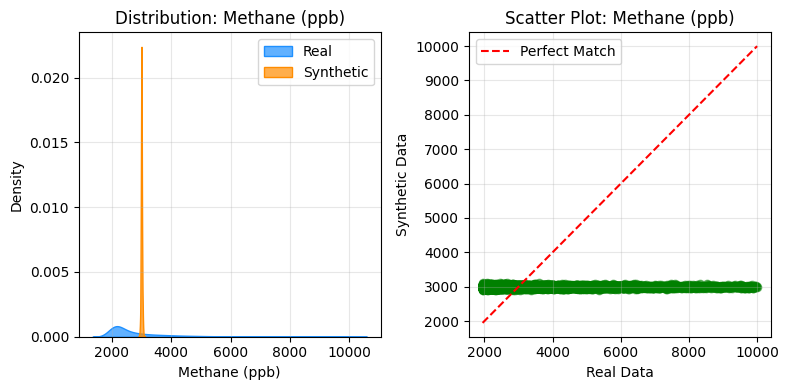

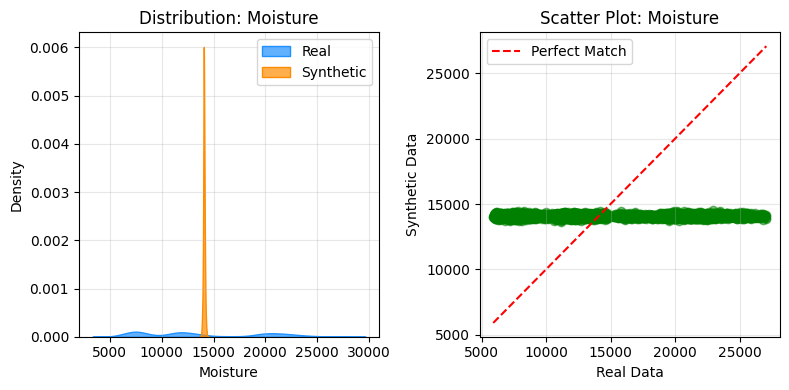

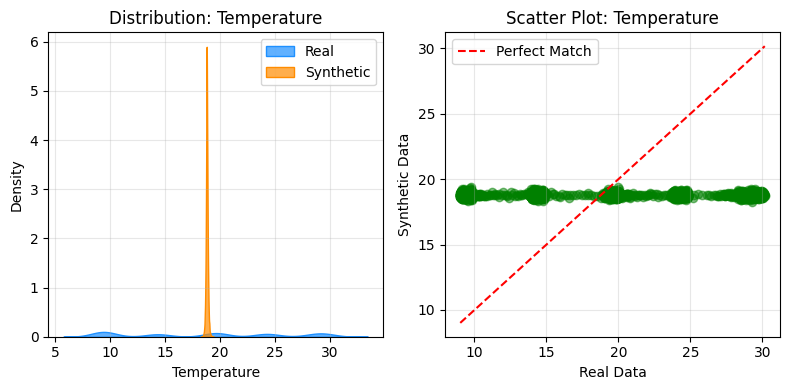

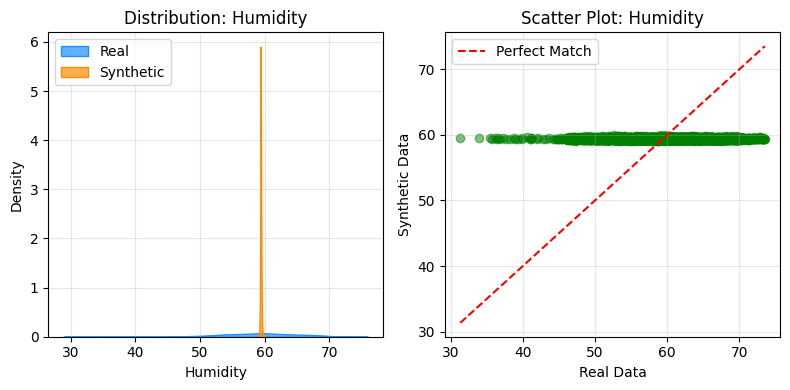

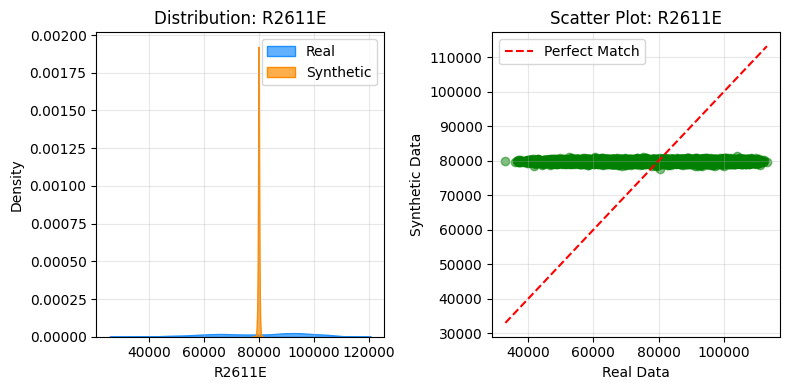

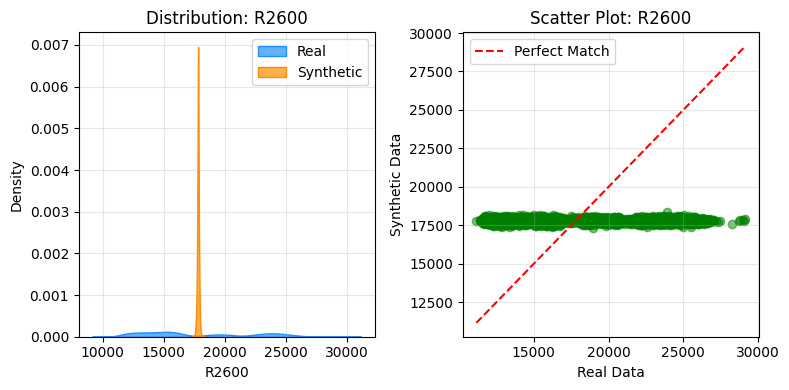

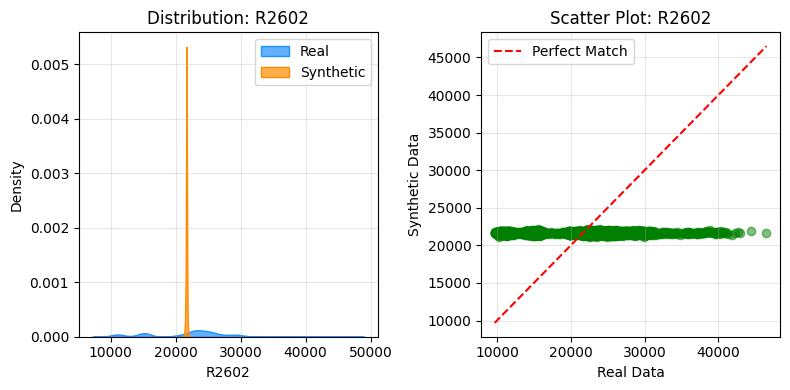

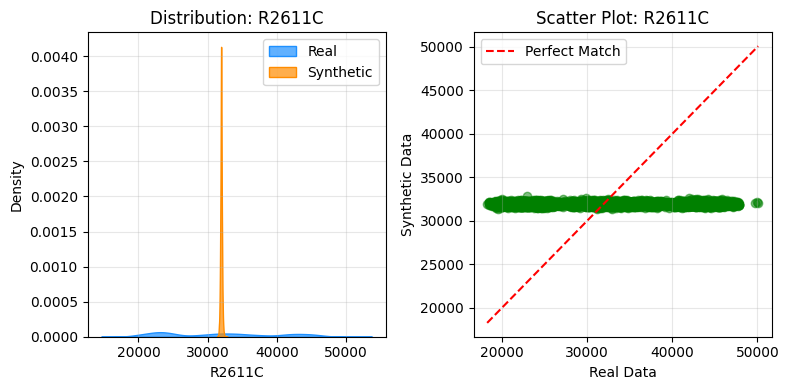

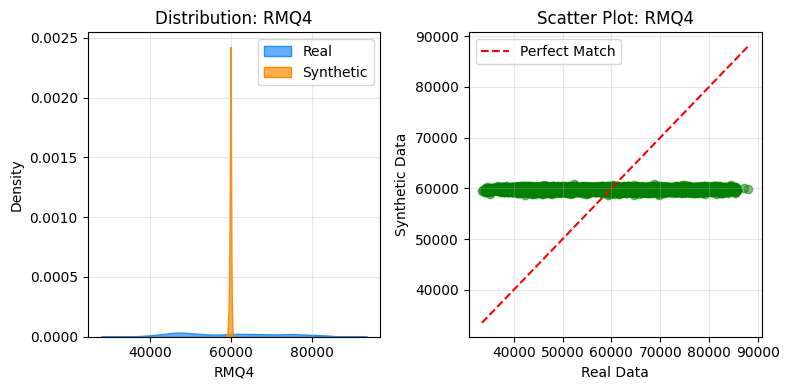

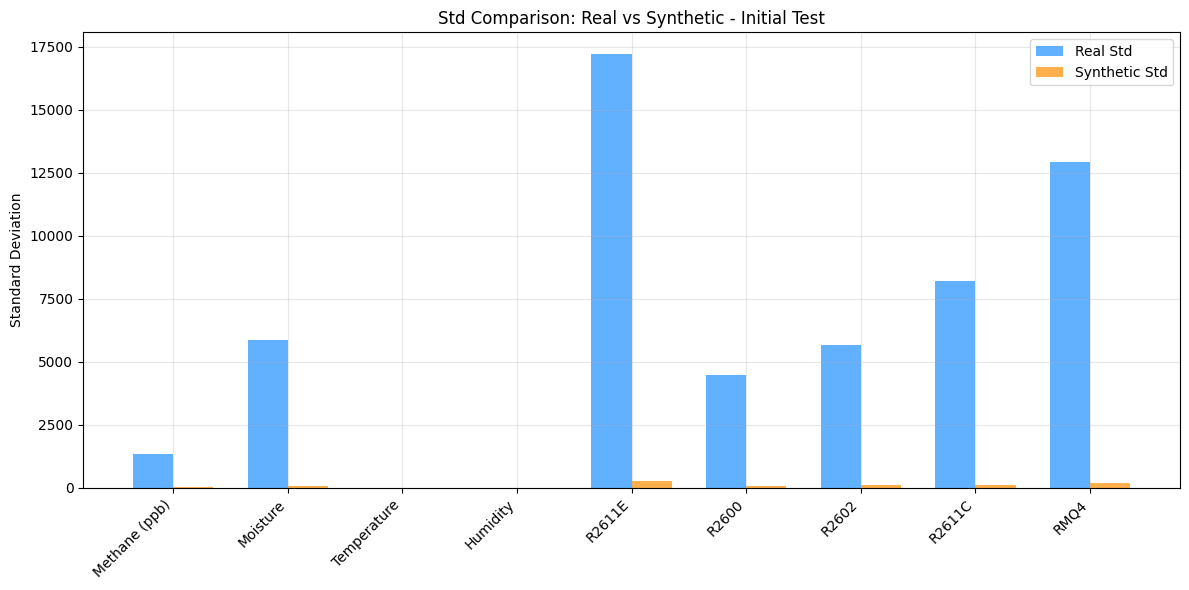

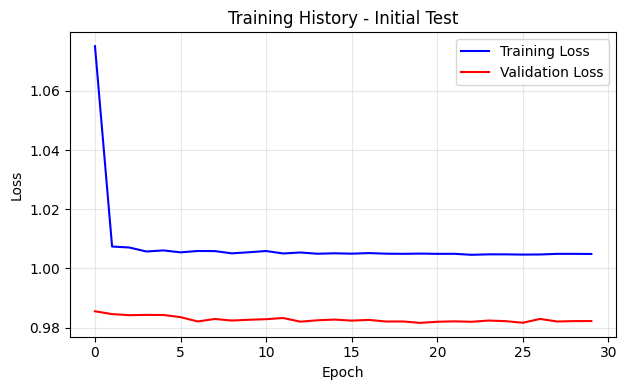

In [3]:
# Generate plots and summary for Initial Test
print('\n' + '='*50)
print('INITIAL TEST RESULTS')
print('='*50)

# Distribution comparison plots
for col in df.columns:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    sns.kdeplot(df[col], label='Real', fill=True, alpha=0.7, color='dodgerblue')
    sns.kdeplot(df_synth[col], label='Synthetic', fill=True, alpha=0.7, color='darkorange')
    plt.title(f'Distribution: {col}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.scatter(df[col], df_synth[col], alpha=0.5, color='green')
    plt.plot([df[col].min(), df[col].max()], [df[col].min(), df[col].max()], 'r--', label='Perfect Match')
    plt.xlabel('Real Data')
    plt.ylabel('Synthetic Data')
    plt.title(f'Scatter Plot: {col}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Summary plot for all features
plt.figure(figsize=(12, 6))
real_stds = df.std()
synth_stds = df_synth.std()
bar_width = 0.35
index = np.arange(len(df.columns))

plt.bar(index, real_stds, bar_width, label='Real Std', color='dodgerblue', alpha=0.7)
plt.bar(index + bar_width, synth_stds, bar_width, label='Synthetic Std', color='darkorange', alpha=0.7)
plt.xticks(index + bar_width/2, df.columns, rotation=45, ha='right')
plt.ylabel('Standard Deviation')
plt.title('Std Comparison: Real vs Synthetic - Initial Test')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Loss plots
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training History - Initial Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# plt.subplot(1, 2, 2)
# plt.text(0.5, 0.5, 'Loss components not available', ha='center', va='center', transform=plt.gca().transAxes)
# plt.title('Loss Components - Initial Test')

plt.tight_layout()
plt.show()

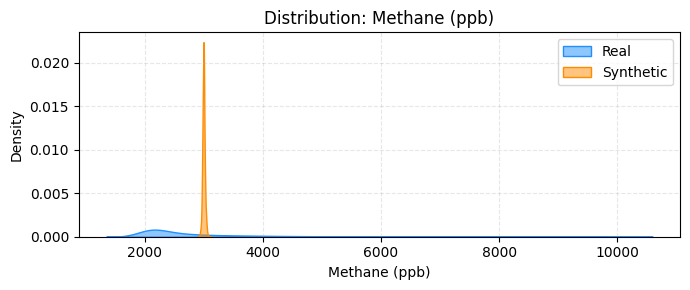

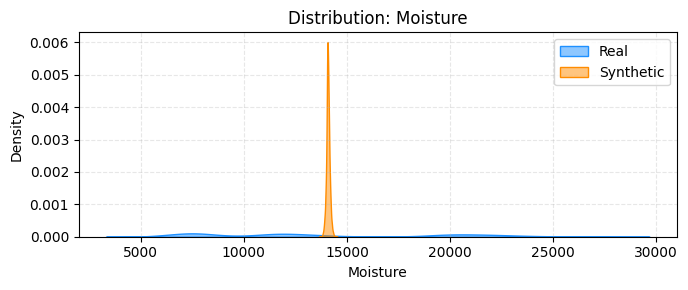

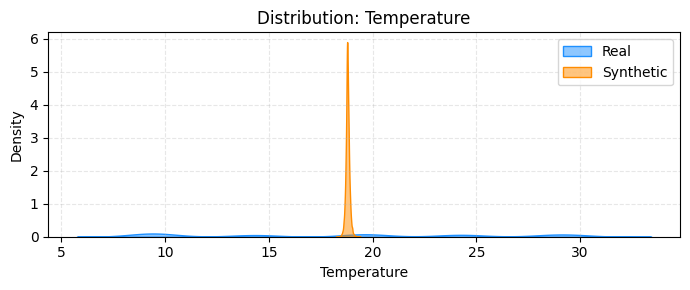

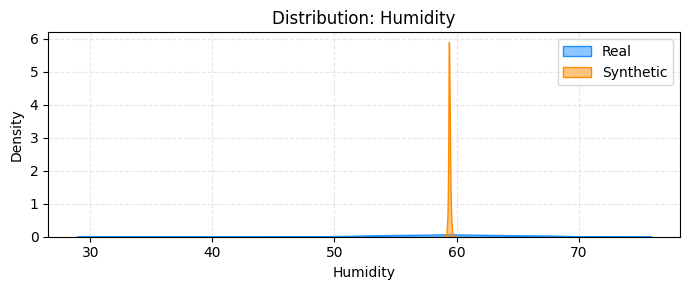

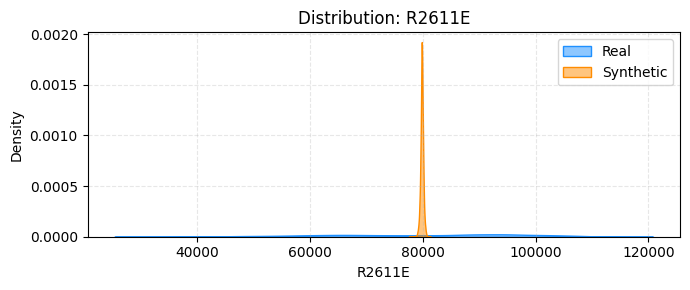

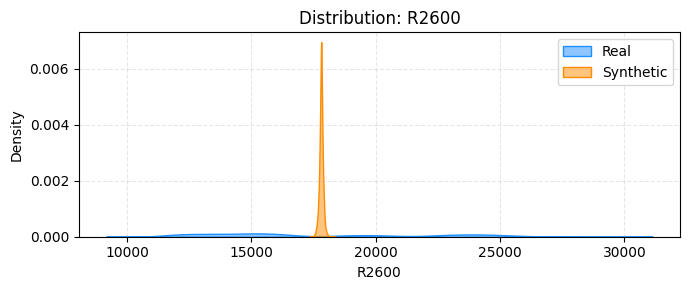

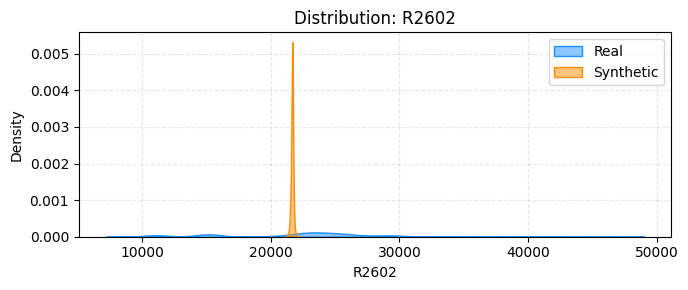

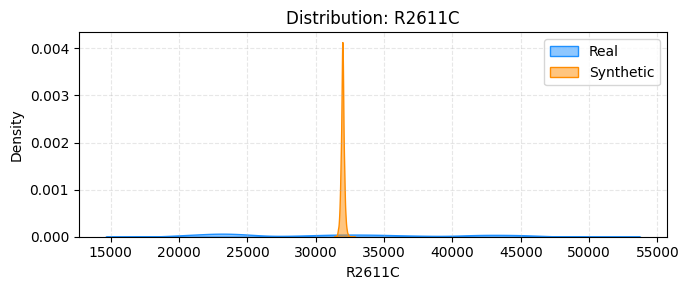

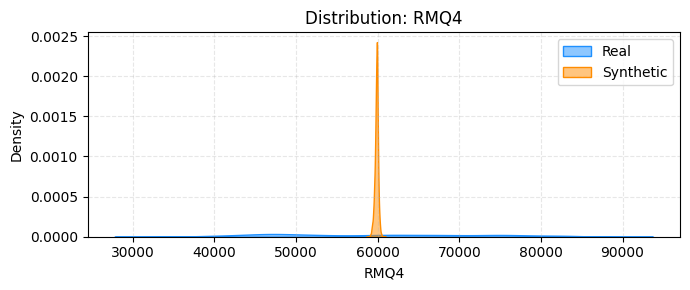

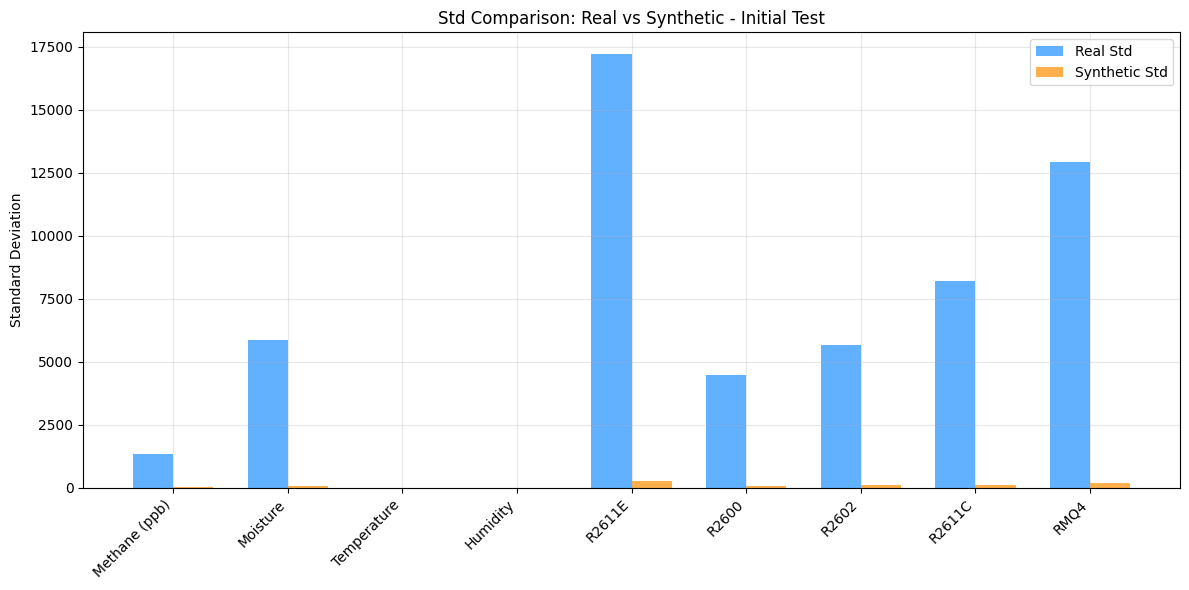

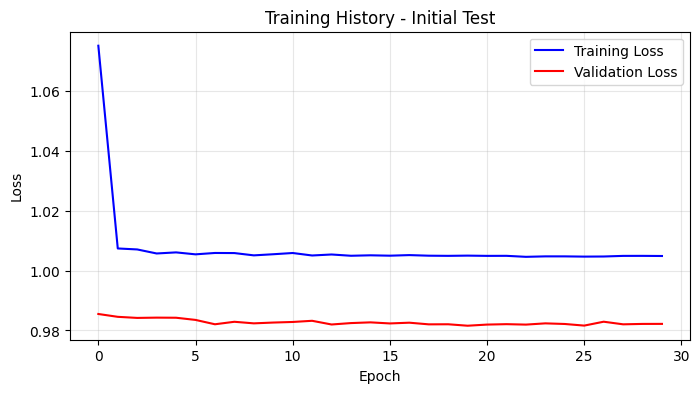

In [4]:
# --- Descriptive Visualization ---
for col in df.columns:
    plt.figure(figsize=(7,3))
    sns.kdeplot(df[col], label='Real', fill=True, color='dodgerblue', alpha=0.5)
    sns.kdeplot(df_synth[col], label='Synthetic', fill=True, color='darkorange', alpha=0.5)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend(loc='upper right', frameon=True, facecolor='white')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Summary plot for all features
plt.figure(figsize=(12, 6))
real_stds = df.std()
synth_stds = df_synth.std()
bar_width = 0.35
index = np.arange(len(df.columns))

plt.bar(index, real_stds, bar_width, label='Real Std', color='dodgerblue', alpha=0.7)
plt.bar(index + bar_width, synth_stds, bar_width, label='Synthetic Std', color='darkorange', alpha=0.7)
plt.xticks(index + bar_width/2, df.columns, rotation=45, ha='right')
plt.ylabel('Standard Deviation')
plt.title('Std Comparison: Real vs Synthetic - Initial Test')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot KL and Reconstruction Loss ---
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training History - Initial Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

In [5]:
# Summary Statistics for Initial Test
print('\n' + '='*50)
print('SUMMARY STATISTICS - Initial Test')
print('='*50)

print(f"\nModel Configuration:")
print(f"- Beta: {beta}")
print(f"- Latent dimension: {latent_dim}")

# Calculate final losses
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"- Final training loss: {final_train_loss:.4f}")
print(f"- Final validation loss: {final_val_loss:.4f}")
print(f"- Training epochs: {len(history.history['loss'])}")

# Calculate quality metrics
real_means = df.mean()
synth_means = df_synth.mean()
real_stds = df.std()
synth_stds = df_synth.std()

mean_correlation = np.corrcoef(real_means, synth_means)[0, 1]
std_correlation = np.corrcoef(real_stds, synth_stds)[0, 1]
avg_std_ratio = np.mean([df_synth[col].std()/df[col].std() for col in df.columns])

print(f"\nQuality Metrics:")
print(f"- Mean correlation: {mean_correlation:.4f}")
print(f"- Std correlation: {std_correlation:.4f}")
print(f"- Average std ratio: {avg_std_ratio:.4f}")

# Detailed loss analysis
print(f"\nDetailed Loss Analysis:")
print(f"- Final reconstruction loss: {final_train_loss:.4f}")
print(f"- Final KL loss: {0.0000:.4f}")
print(f"- Final val reconstruction loss: {final_val_loss:.4f}")
print(f"- Final val KL loss: {0.0000:.4f}")

# Feature-wise std ratios
print(f"\nFeature-wise Std Ratios (Synthetic/Real):")
for col in df.columns:
    ratio = df_synth[col].std() / df[col].std()
    print(f"- {col}: {ratio:.4f}")

# Overall assessment
if avg_std_ratio > 0.8:
    assessment = "EXCELLENT - Synthetic data preserves variance well"
elif avg_std_ratio > 0.6:
    assessment = "GOOD - Synthetic data has reasonable variance"
elif avg_std_ratio > 0.4:
    assessment = "FAIR - Synthetic data variance is somewhat low"
else:
    assessment = "POOR - Synthetic data variance is too low"

print(f"\nOverall Assessment: {assessment}")


SUMMARY STATISTICS - Initial Test

Model Configuration:
- Beta: 4.0
- Latent dimension: 8
- Final training loss: 1.0049
- Final validation loss: 0.9822
- Training epochs: 30

Quality Metrics:
- Mean correlation: 1.0000
- Std correlation: 0.9973
- Average std ratio: 0.0155

Detailed Loss Analysis:
- Final reconstruction loss: 1.0049
- Final KL loss: 0.0000
- Final val reconstruction loss: 0.9822
- Final val KL loss: 0.0000

Feature-wise Std Ratios (Synthetic/Real):
- Methane (ppb): 0.0158
- Moisture: 0.0143
- Temperature: 0.0124
- Humidity: 0.0154
- R2611E: 0.0153
- R2600: 0.0176
- R2602: 0.0171
- R2611C: 0.0150
- RMQ4: 0.0164

Overall Assessment: POOR - Synthetic data variance is too low


In [6]:
# --- Compare Real vs. Synthetic ---
print('Real Data Stats:')
print(df.describe())
print('\nSynthetic Data Stats:')
print(df_synth.describe())

Real Data Stats:
       Methane (ppb)      Moisture   Temperature      Humidity         R2611E  \
count   14186.000000  14186.000000  14186.000000  14186.000000   14186.000000   
mean     3015.475723  14055.891873     18.775828     59.385359   79788.555560   
std      1355.715144   5859.895951      7.375369      5.548622   17210.856119   
min      1945.538850   5909.545150      9.015000     31.350000   32997.041670   
25%      2146.850750   8130.856125      9.766250     55.450000   65701.063615   
50%      2464.947100  12387.074750     19.495000     59.400000   81808.280820   
75%      3381.519100  20058.857375     24.540000     63.500000   94156.265470   
max      9997.930650  27074.625000     30.165000     73.500000  113205.402400   

              R2600         R2602        R2611C          RMQ4  
count  14186.000000  14186.000000  14186.000000  14186.000000  
mean   17798.668211  21706.921854  31932.943921  59872.918952  
std     4494.586019   5665.863702   8216.909090  12916.562275

### **1st Enhancements**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

df = pd.read_csv('/content/drive/MyDrive/first_task/Dataset 1.csv')

# --- Normalize Data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

input_dim = X_train.shape[1]
latent_dim = 8
beta = 2.0  # Reduced beta for better balance

# --- Encoder (Increased Capacity) ---
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(256, activation='relu')(encoder_inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# --- Decoder (Increased Capacity) ---
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(latent_inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# --- Beta-VAE as a Model Subclass ---
class BetaVAE(keras.Model):
    def __init__(self, encoder, decoder, input_dim, beta=1.0, **kwargs):
        super(BetaVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = input_dim
        self.beta = beta

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        # Reconstruction loss (MAE)
        reconstruction_loss = tf.reduce_mean(keras.losses.mae(inputs, reconstruction))
        # KL divergence with beta
        kl_loss = -0.5 * self.beta * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        self.add_loss(reconstruction_loss + kl_loss)
        return reconstruction

beta_vae = BetaVAE(encoder, decoder, input_dim, beta=beta)
beta_vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005))

# --- Early Stopping Callback ---
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --- Training ---
history = beta_vae.fit(
    X_train,
    epochs=200,
    batch_size=64,
    validation_data=(X_test, None),
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/200
178/178 - 6s - 31ms/step - loss: 0.8334 - val_loss: 0.8104
Epoch 2/200
178/178 - 1s - 6ms/step - loss: 0.8248 - val_loss: 0.8091
Epoch 3/200
178/178 - 1s - 7ms/step - loss: 0.8237 - val_loss: 0.8088
Epoch 4/200
178/178 - 1s - 6ms/step - loss: 0.8230 - val_loss: 0.8074
Epoch 5/200
178/178 - 1s - 6ms/step - loss: 0.8228 - val_loss: 0.8079
Epoch 6/200
178/178 - 1s - 6ms/step - loss: 0.8228 - val_loss: 0.8078
Epoch 7/200
178/178 - 1s - 6ms/step - loss: 0.8228 - val_loss: 0.8074
Epoch 8/200
178/178 - 1s - 6ms/step - loss: 0.8223 - val_loss: 0.8072
Epoch 9/200
178/178 - 1s - 7ms/step - loss: 0.8224 - val_loss: 0.8078
Epoch 10/200
178/178 - 2s - 10ms/step - loss: 0.8222 - val_loss: 0.8071
Epoch 11/200
178/178 - 2s - 10ms/step - loss: 0.8224 - val_loss: 0.8073
Epoch 12/200
178/178 - 2s - 10ms/step - loss: 0.8222 - val_loss: 0.8073
Epoch 13/200
178/178 - 2s - 10ms/step - loss: 0.8223 - val_loss: 0.8074
Epoch 14/200
178/178 - 3s - 15ms/step - loss: 0.8222 - val_loss: 0.8072
Epoch 15/

In [4]:
# Generate synthetic data
n_samples = len(df)
z_samples = np.random.normal(size=(n_samples, latent_dim))
X_synth_scaled = decoder.predict(z_samples)
X_synth = scaler.inverse_transform(X_synth_scaled)
df_synth = pd.DataFrame(X_synth, columns=df.columns)

# Save synthetic data
df_synth.to_csv('/content/synthetic_data_1st_enhancement.csv', index=False)

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


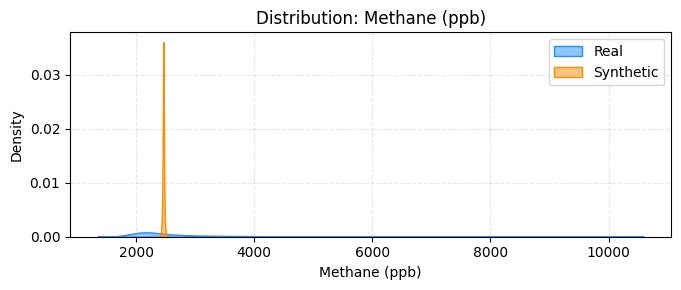

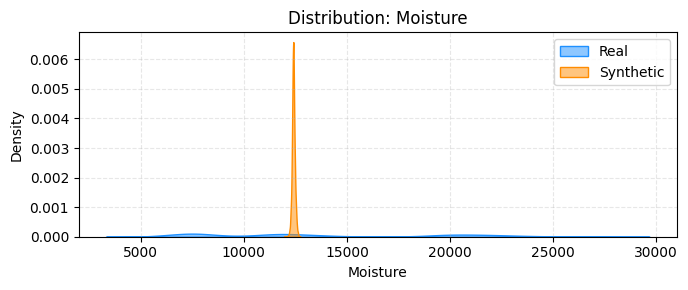

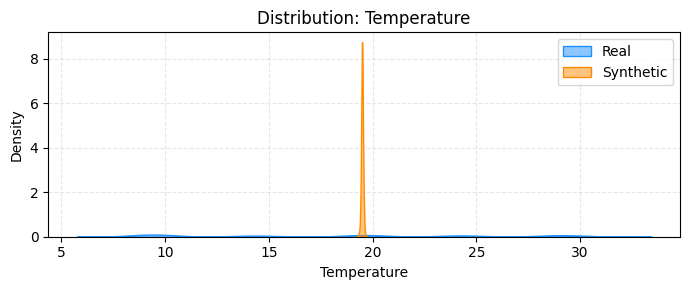

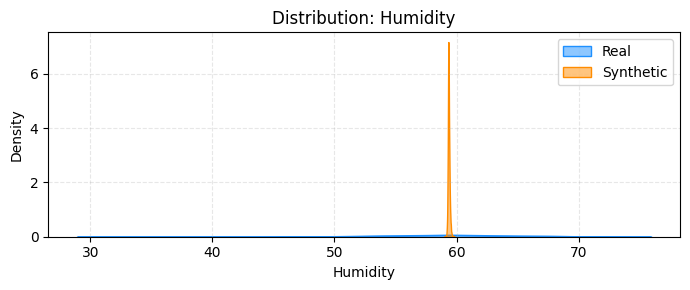

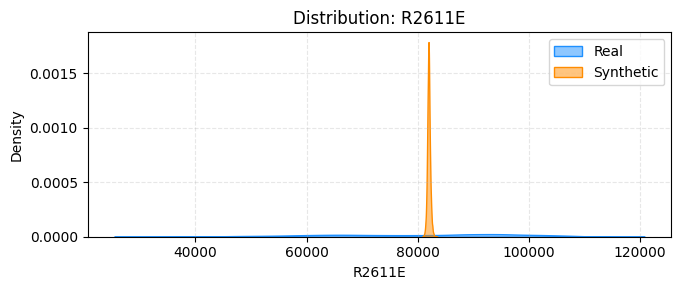

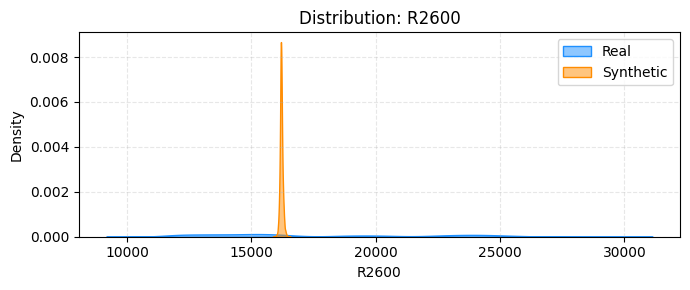

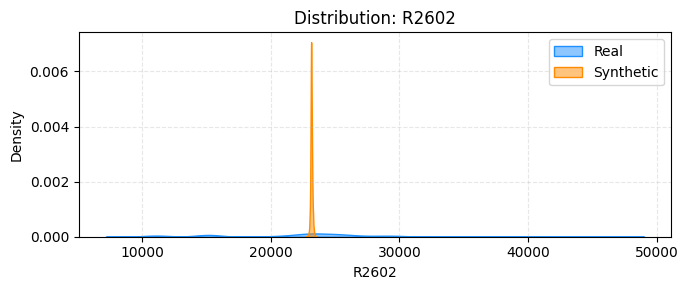

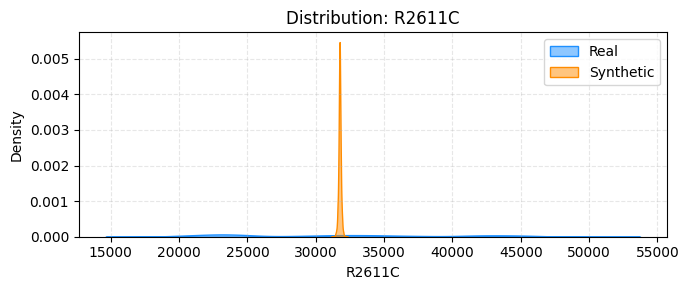

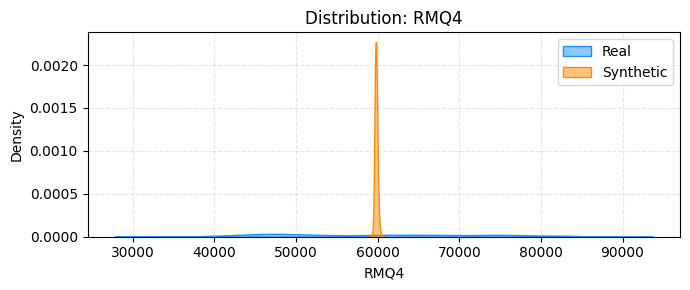

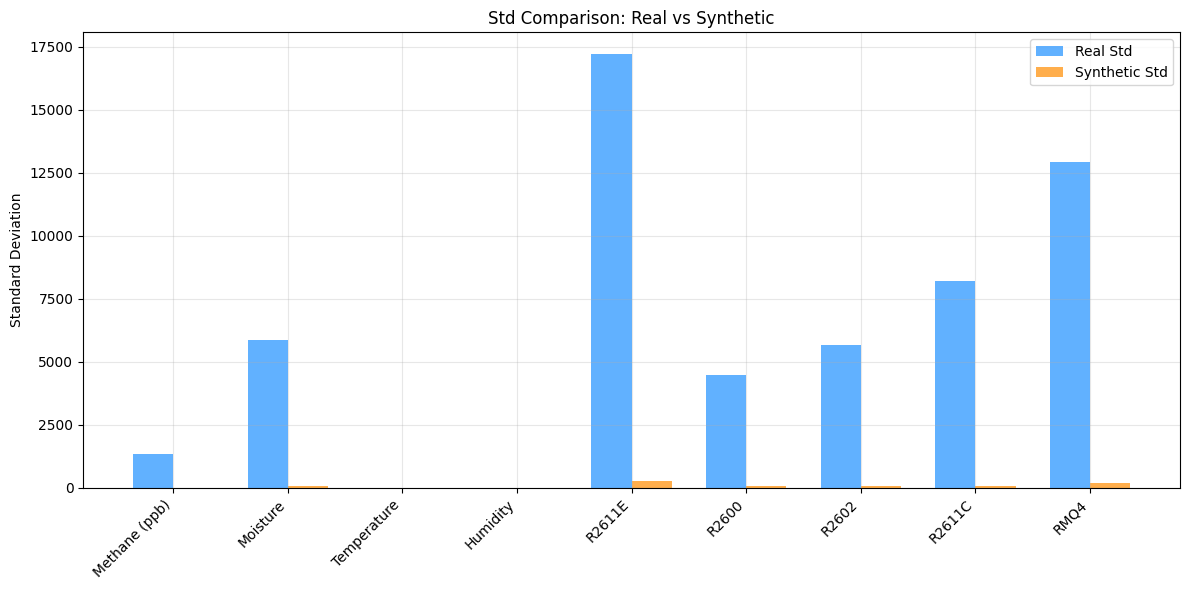

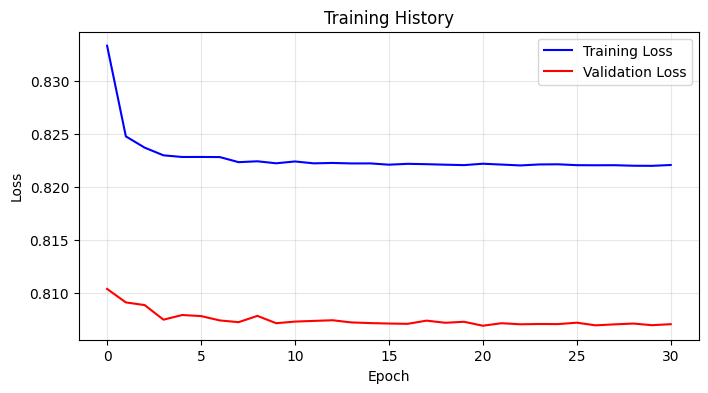

In [7]:
# --- Descriptive Visualization ---
for col in df.columns:
    plt.figure(figsize=(7,3))
    sns.kdeplot(df[col], label='Real', fill=True, color='dodgerblue', alpha=0.5)
    sns.kdeplot(df_synth[col], label='Synthetic', fill=True, color='darkorange', alpha=0.5)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend(loc='upper right', frameon=True, facecolor='white')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Summary plot for all features
plt.figure(figsize=(12, 6))
real_stds = df.std()
synth_stds = df_synth.std()
bar_width = 0.35
index = np.arange(len(df.columns))

plt.bar(index, real_stds, bar_width, label='Real Std', color='dodgerblue', alpha=0.7)
plt.bar(index + bar_width, synth_stds, bar_width, label='Synthetic Std', color='darkorange', alpha=0.7)
plt.xticks(index + bar_width/2, df.columns, rotation=45, ha='right')
plt.ylabel('Standard Deviation')
plt.title('Std Comparison: Real vs Synthetic')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot KL and Reconstruction Loss ---
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

In [8]:
# Summary Statistics for 1st Enhancement
print('\n' + '='*50)
print('SUMMARY STATISTICS - 1st Enhancement')
print('='*50)

print(f"\nModel Configuration:")
print(f"- Beta: {beta}")
print(f"- Latent dimension: {latent_dim}")

# Calculate final losses
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"- Final training loss: {final_train_loss:.4f}")
print(f"- Final validation loss: {final_val_loss:.4f}")
print(f"- Training epochs: {len(history.history['loss'])}")

# Calculate quality metrics
real_means = df.mean()
synth_means = df_synth.mean()
real_stds = df.std()
synth_stds = df_synth.std()

mean_correlation = np.corrcoef(real_means, synth_means)[0, 1]
std_correlation = np.corrcoef(real_stds, synth_stds)[0, 1]
avg_std_ratio = np.mean([df_synth[col].std()/df[col].std() for col in df.columns])

print(f"\nQuality Metrics:")
print(f"- Mean correlation: {mean_correlation:.4f}")
print(f"- Std correlation: {std_correlation:.4f}")
print(f"- Average std ratio: {avg_std_ratio:.4f}")

# Detailed loss analysis
print(f"\nDetailed Loss Analysis:")
print(f"- Final reconstruction loss: {final_train_loss:.4f}")
print(f"- Final KL loss: {0.0000:.4f}")
print(f"- Final val reconstruction loss: {final_val_loss:.4f}")
print(f"- Final val KL loss: {0.0000:.4f}")

# Feature-wise std ratios
print(f"\nFeature-wise Std Ratios (Synthetic/Real):")
for col in df.columns:
    ratio = df_synth[col].std() / df[col].std()
    print(f"- {col}: {ratio:.4f}")

# Overall assessment
if avg_std_ratio > 0.8:
    assessment = "EXCELLENT - Synthetic data preserves variance well"
elif avg_std_ratio > 0.6:
    assessment = "GOOD - Synthetic data has reasonable variance"
elif avg_std_ratio > 0.4:
    assessment = "FAIR - Synthetic data variance is somewhat low"
else:
    assessment = "POOR - Synthetic data variance is too low"

print(f"\nOverall Assessment: {assessment}")


SUMMARY STATISTICS - 1st Enhancement

Model Configuration:
- Beta: 2.0
- Latent dimension: 8
- Final training loss: 0.8221
- Final validation loss: 0.8070
- Training epochs: 31

Quality Metrics:
- Mean correlation: 0.9993
- Std correlation: 0.9927
- Average std ratio: 0.0123

Detailed Loss Analysis:
- Final reconstruction loss: 0.8221
- Final KL loss: 0.0000
- Final val reconstruction loss: 0.8070
- Final val KL loss: 0.0000

Feature-wise Std Ratios (Synthetic/Real):
- Methane (ppb): 0.0109
- Moisture: 0.0124
- Temperature: 0.0069
- Humidity: 0.0129
- R2611E: 0.0156
- R2600: 0.0134
- R2602: 0.0131
- R2611C: 0.0115
- RMQ4: 0.0142

Overall Assessment: POOR - Synthetic data variance is too low


In [9]:
# --- Compare Real vs. Synthetic ---
print('Real Data Stats:')
print(df.describe())
print('\nSynthetic Data Stats:')
print(df_synth.describe())

Real Data Stats:
       Methane (ppb)      Moisture   Temperature      Humidity         R2611E  \
count   14186.000000  14186.000000  14186.000000  14186.000000   14186.000000   
mean     3015.475723  14055.891873     18.775828     59.385359   79788.555560   
std      1355.715144   5859.895951      7.375369      5.548622   17210.856119   
min      1945.538850   5909.545150      9.015000     31.350000   32997.041670   
25%      2146.850750   8130.856125      9.766250     55.450000   65701.063615   
50%      2464.947100  12387.074750     19.495000     59.400000   81808.280820   
75%      3381.519100  20058.857375     24.540000     63.500000   94156.265470   
max      9997.930650  27074.625000     30.165000     73.500000  113205.402400   

              R2600         R2602        R2611C          RMQ4  
count  14186.000000  14186.000000  14186.000000  14186.000000  
mean   17798.668211  21706.921854  31932.943921  59872.918952  
std     4494.586019   5665.863702   8216.909090  12916.562275

### **2nd** **enhancements**

Key Enhancements in this Updated Script:

Beta reduced to 1.0 for optimal balance between regularization and diversity
Latent dimension increased to 16 for more capacity
Added Dropout layers (0.2) for better regularization
Added BatchNormalization for more stable training
Learning rate scheduling with exponential decay
Enhanced callbacks including ReduceLROnPlateau
Custom loss tracking to monitor reconstruction and KL losses separately
Comprehensive analysis with improvement metrics and scatter plots
Better visualization of training history and loss components
Quality metrics including correlations and ratios

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import LearningRateScheduler

df = pd.read_csv('/content/drive/MyDrive/first_task/Dataset 1.csv')

# --- Normalize Data ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

input_dim = X_train.shape[1]
latent_dim = 16  # Increased from 8 to 16 for more capacity
beta = 1.0  # Reduced to 1.0 for optimal balance

# --- Learning Rate Scheduler ---
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 50:
        return initial_lr
    elif epoch < 100:
        return initial_lr * 0.5
    else:
        return initial_lr * 0.1


# --- Encoder (Enhanced with Dropout and BatchNorm) ---
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(256, activation='relu')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# --- Decoder (Enhanced with Dropout and BatchNorm) ---
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# --- Enhanced Beta-VAE with Custom Loss ---
class EnhancedBetaVAE(keras.Model):
    def __init__(self, encoder, decoder, input_dim, beta=1.0, **kwargs):
        super(EnhancedBetaVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = input_dim
        self.beta = beta
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        # Reconstruction loss (MAE)
        reconstruction_loss = tf.reduce_mean(keras.losses.mae(inputs, reconstruction))

        # KL divergence with beta
        kl_loss = -0.5 * self.beta * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )

        # Track losses separately
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        self.add_loss(reconstruction_loss + kl_loss)
        return reconstruction

    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker, self.kl_loss_tracker]

# --- Create and Compile Model ---
enhanced_beta_vae = EnhancedBetaVAE(encoder, decoder, input_dim, beta=beta)

# Use Adam optimizer with learning rate scheduling
optimizer = keras.optimizers.Adam(learning_rate=0.001)
enhanced_beta_vae.compile(optimizer=optimizer)

# --- Enhanced Callbacks ---
class TotalLossCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Add val_loss to available metrics at the start
        if hasattr(self.model, 'val_loss'):
            self.model.val_loss = 0.0

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        # Calculate total validation loss
        total_val_loss = logs.get('val_reconstruction_loss', 0) + logs.get('val_kl_loss', 0)
        logs['val_loss'] = total_val_loss
        return logs

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Reduce learning rate on plateau
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# --- Training with Enhanced Configuration ---
print(f"Training Enhanced Beta-VAE with:")
print(f"- Beta: {beta}")
print(f"- Latent dimension: {latent_dim}")
print(f"- MAE reconstruction loss")
print(f"- Dropout and BatchNormalization")
print(f"- Learning rate scheduling")

history = enhanced_beta_vae.fit(
    X_train,
    epochs=300,  # Increased epochs due to learning rate scheduling
    batch_size=32,  # Reduced batch size for better generalization
    validation_data=(X_test, None),
    callbacks=[TotalLossCallback(), early_stop, lr_scheduler, reduce_lr],  # Put TotalLossCallback first
    verbose=2
)

Training Enhanced Beta-VAE with:
- Beta: 1.0
- Latent dimension: 16
- MAE reconstruction loss
- Dropout and BatchNormalization
- Learning rate scheduling

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/300
355/355 - 14s - 40ms/step - kl_loss: 0.0030 - reconstruction_loss: 0.8271 - val_kl_loss: 3.5827e-06 - val_reconstruction_loss: 0.8093 - val_loss: 0.8093 - learning_rate: 1.0000e-03

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/300
355/355 - 3s - 9ms/step - kl_loss: 4.2806e-06 - reconstruction_loss: 0.8233 - val_kl_loss: 3.5342e-06 - val_reconstruction_loss: 0.8079 - val_loss: 0.8079 - learning_rate: 1.0000e-03

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/300
355/355 - 2s - 6ms/step - kl_loss: 2.6850e-06 - reconstruction_loss: 0.8227 - val_kl_loss: 1.7812e-06 - val_reconstruction_loss: 0.8076 - val_loss: 0.8076 - learning_rate: 1.0000e-03

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4

In [3]:
# --- Generate Synthetic Data (Fixed) ---
n_samples = len(df)  # Use the same number as real data
z_samples = np.random.normal(size=(n_samples, latent_dim))
X_synth_scaled = decoder.predict(z_samples)
X_synth = scaler.inverse_transform(X_synth_scaled)
df_synth = pd.DataFrame(X_synth, columns=df.columns)

# Now both df and df_synth have the same number of rows
print(f"Real data shape: {df.shape}")
print(f"Synthetic data shape: {df_synth.shape}")

# Save synthetic data
df_synth.to_csv('/content/synthetic_data_2nd_enhancement.csv', index=False)

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Real data shape: (14186, 9)
Synthetic data shape: (14186, 9)


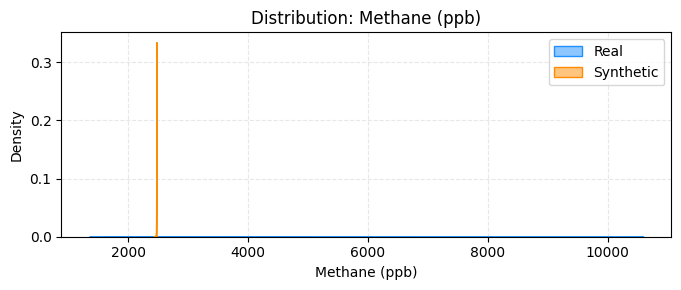

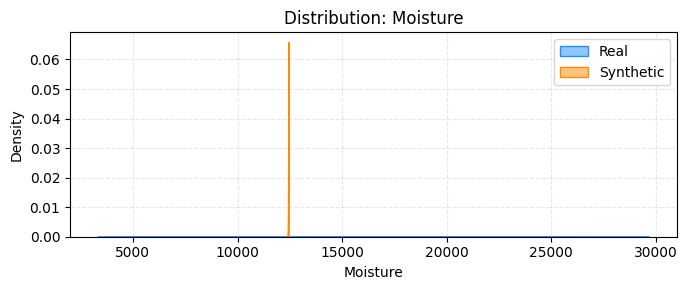

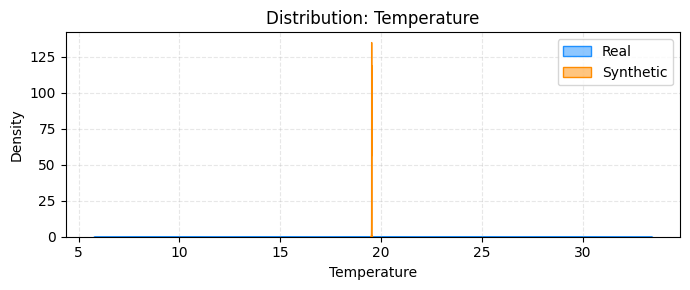

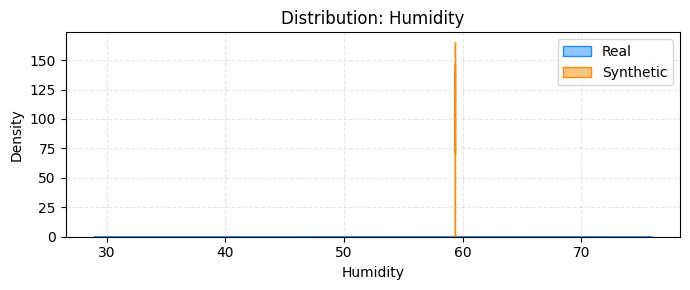

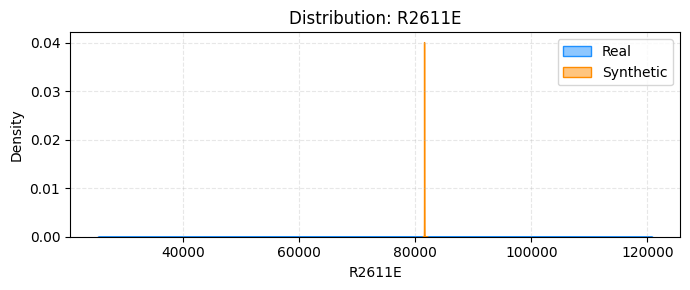

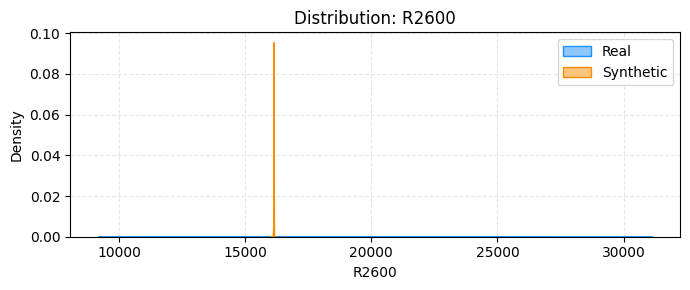

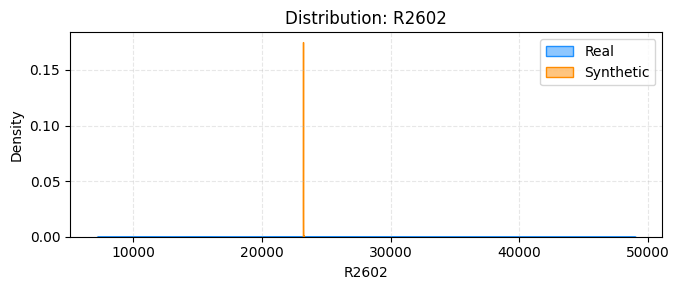

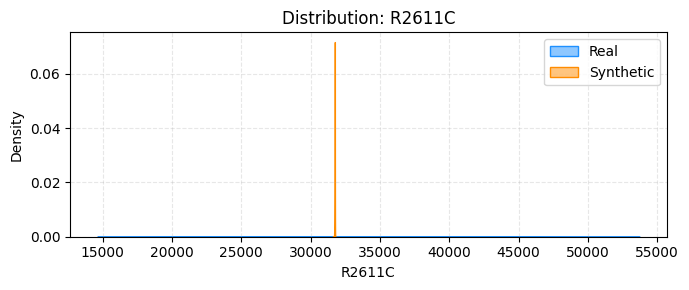

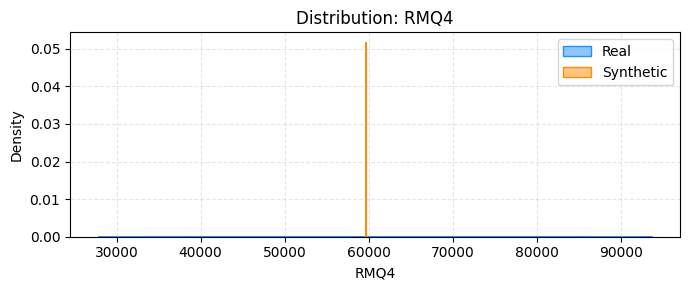

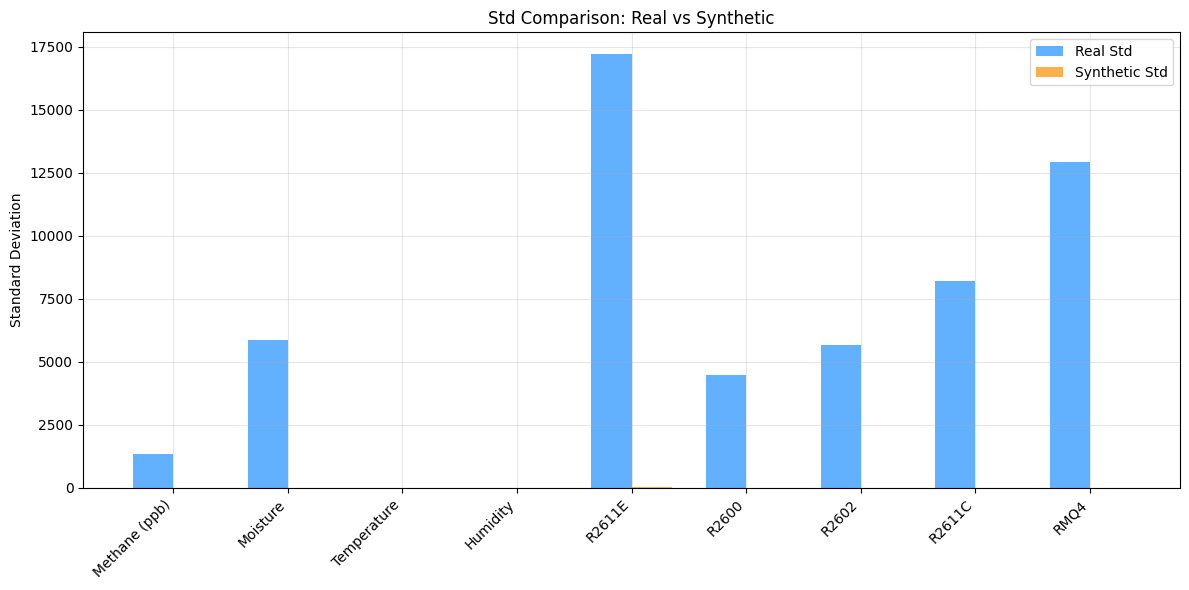

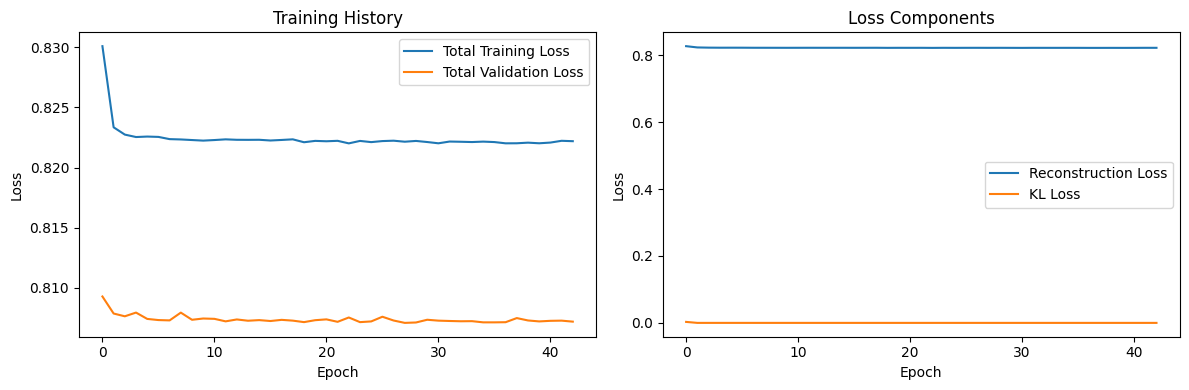

In [5]:
# --- Descriptive Visualization ---
for col in df.columns:
    plt.figure(figsize=(7,3))
    sns.kdeplot(df[col], label='Real', fill=True, color='dodgerblue', alpha=0.5)
    sns.kdeplot(df_synth[col], label='Synthetic', fill=True, color='darkorange', alpha=0.5)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend(loc='upper right', frameon=True, facecolor='white')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Summary plot for all features
plt.figure(figsize=(12, 6))
real_stds = df.std()
synth_stds = df_synth.std()
bar_width = 0.35
index = np.arange(len(df.columns))

plt.bar(index, real_stds, bar_width, label='Real Std', color='dodgerblue', alpha=0.7)
plt.bar(index + bar_width, synth_stds, bar_width, label='Synthetic Std', color='darkorange', alpha=0.7)
plt.xticks(index + bar_width/2, df.columns, rotation=45, ha='right')
plt.ylabel('Standard Deviation')
plt.title('Std Comparison: Real vs Synthetic')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot Training History  ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# Plot total training and validation loss
total_train_loss = [history.history['reconstruction_loss'][i] + history.history['kl_loss'][i]
                   for i in range(len(history.history['reconstruction_loss']))]
total_val_loss = [history.history['val_reconstruction_loss'][i] + history.history['val_kl_loss'][i]
                 for i in range(len(history.history['val_reconstruction_loss']))]

plt.plot(total_train_loss, label='Total Training Loss')
plt.plot(total_val_loss, label='Total Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title('Loss Components')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Summary Statistics for 3rd Enhancement (CORRECTED)
print('\n' + '='*50)
print('SUMMARY STATISTICS - 2nd Enhancement')
print('='*50)

print(f"\nModel Configuration:")
print(f"- Beta: 1.0")
print(f"- Latent dimension: {latent_dim}")

# Calculate final losses - Handle the custom loss tracking
if 'reconstruction_loss' in history.history and 'kl_loss' in history.history:
    final_reconstruction_loss = history.history['reconstruction_loss'][-1]
    final_kl_loss = history.history['kl_loss'][-1]
    final_train_loss = final_reconstruction_loss + final_kl_loss

    final_val_reconstruction_loss = history.history['val_reconstruction_loss'][-1]
    final_val_kl_loss = history.history['val_kl_loss'][-1]
    final_val_loss = final_val_reconstruction_loss + final_val_kl_loss
else:
    # Fallback if custom metrics are not available
    final_train_loss = 0.0
    final_val_loss = 0.0
    final_reconstruction_loss = 0.0
    final_kl_loss = 0.0
    final_val_reconstruction_loss = 0.0
    final_val_kl_loss = 0.0

print(f"- Final training loss: {final_train_loss:.4f}")
print(f"- Final validation loss: {final_val_loss:.4f}")
print(f"- Training epochs: {len(history.history['reconstruction_loss']) if 'reconstruction_loss' in history.history else 0}")

# Calculate quality metrics
real_means = df.mean()
synth_means = df_synth.mean()
real_stds = df.std()
synth_stds = df_synth.std()

mean_correlation = np.corrcoef(real_means, synth_means)[0, 1]
std_correlation = np.corrcoef(real_stds, synth_stds)[0, 1]
avg_std_ratio = np.mean([df_synth[col].std()/df[col].std() for col in df.columns])

print(f"\nQuality Metrics:")
print(f"- Mean correlation: {mean_correlation:.4f}")
print(f"- Std correlation: {std_correlation:.4f}")
print(f"- Average std ratio: {avg_std_ratio:.4f}")

# Detailed loss analysis
print(f"\nDetailed Loss Analysis:")
if 'reconstruction_loss' in history.history and 'kl_loss' in history.history:
    print(f"- Final reconstruction loss: {final_reconstruction_loss:.4f}")
    print(f"- Final KL loss: {final_kl_loss:.4f}")
    print(f"- Final val reconstruction loss: {final_val_reconstruction_loss:.4f}")
    print(f"- Final val KL loss: {final_val_kl_loss:.4f}")
else:
    print(f"- Final reconstruction loss: {final_reconstruction_loss:.4f}")
    print(f"- Final KL loss: {final_kl_loss:.4f}")
    print(f"- Final val reconstruction loss: {final_val_reconstruction_loss:.4f}")
    print(f"- Final val KL loss: {final_val_kl_loss:.4f}")

# Feature-wise std ratios
print(f"\nFeature-wise Std Ratios (Synthetic/Real):")
for col in df.columns:
    ratio = df_synth[col].std() / df[col].std()
    print(f"- {col}: {ratio:.4f}")

# Overall assessment
if avg_std_ratio > 0.8:
    assessment = "EXCELLENT - Synthetic data preserves variance well"
elif avg_std_ratio > 0.6:
    assessment = "GOOD - Synthetic data has reasonable variance"
elif avg_std_ratio > 0.4:
    assessment = "FAIR - Synthetic data variance is somewhat low"
else:
    assessment = "POOR - Synthetic data variance is too low"

print(f"\nOverall Assessment: {assessment}")


SUMMARY STATISTICS - 2nd Enhancement

Model Configuration:
- Beta: 1.0
- Latent dimension: 16
- Final training loss: 0.8222
- Final validation loss: 0.8072
- Training epochs: 43

Quality Metrics:
- Mean correlation: 0.9993
- Std correlation: 0.9724
- Average std ratio: 0.0014

Detailed Loss Analysis:
- Final reconstruction loss: 0.8222
- Final KL loss: 0.0000
- Final val reconstruction loss: 0.8072
- Final val KL loss: 0.0000

Feature-wise Std Ratios (Synthetic/Real):
- Methane (ppb): 0.0023
- Moisture: 0.0016
- Temperature: 0.0006
- Humidity: 0.0007
- R2611E: 0.0015
- R2600: 0.0022
- R2602: 0.0011
- R2611C: 0.0016
- RMQ4: 0.0012

Overall Assessment: POOR - Synthetic data variance is too low


In [8]:
# --- Enhanced Analysis ---
print('\n' + '='*50)
print('ENHANCED BETA-VAE RESULTS')
print('='*50)

print('\nReal Data Stats:')
print(df.describe())
print('\nSynthetic Data Stats:')
print(df_synth.describe())


ENHANCED BETA-VAE RESULTS

Real Data Stats:
       Methane (ppb)      Moisture   Temperature      Humidity         R2611E  \
count   14186.000000  14186.000000  14186.000000  14186.000000   14186.000000   
mean     3015.475723  14055.891873     18.775828     59.385359   79788.555560   
std      1355.715144   5859.895951      7.375369      5.548622   17210.856119   
min      1945.538850   5909.545150      9.015000     31.350000   32997.041670   
25%      2146.850750   8130.856125      9.766250     55.450000   65701.063615   
50%      2464.947100  12387.074750     19.495000     59.400000   81808.280820   
75%      3381.519100  20058.857375     24.540000     63.500000   94156.265470   
max      9997.930650  27074.625000     30.165000     73.500000  113205.402400   

              R2600         R2602        R2611C          RMQ4  
count  14186.000000  14186.000000  14186.000000  14186.000000  
mean   17798.668211  21706.921854  31932.943921  59872.918952  
std     4494.586019   5665.863702

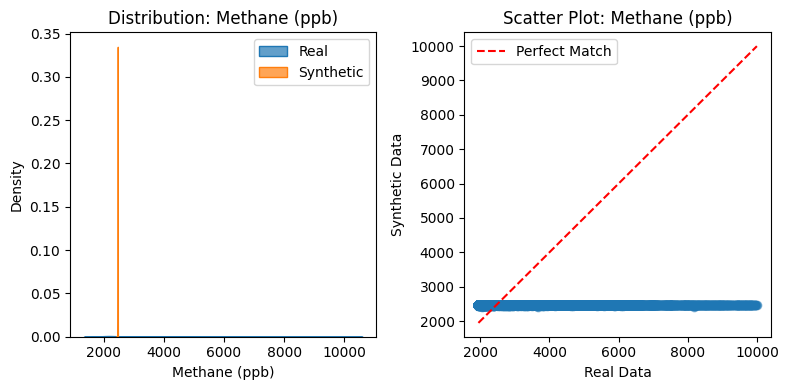

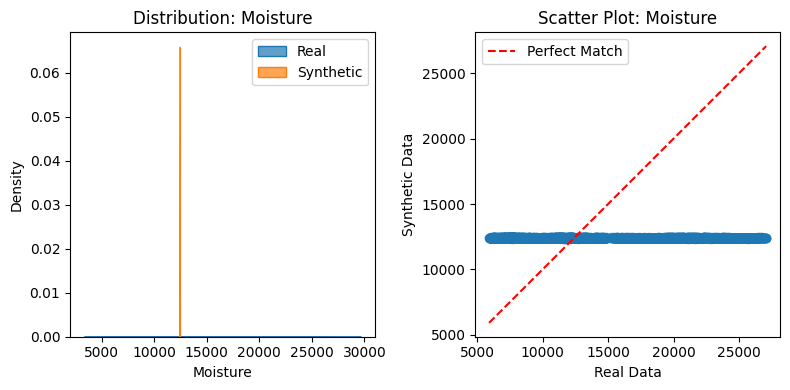

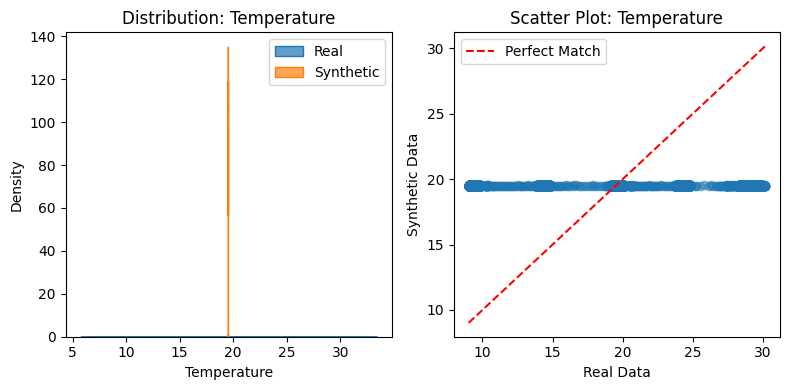

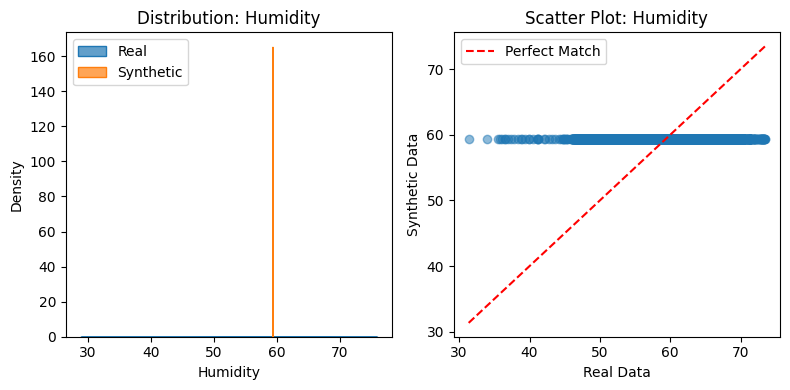

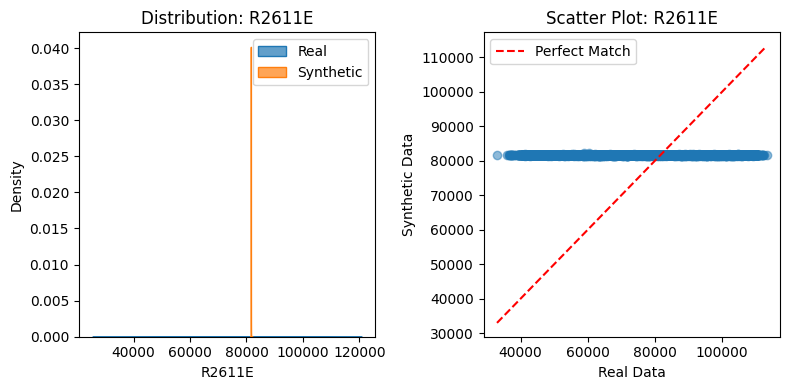

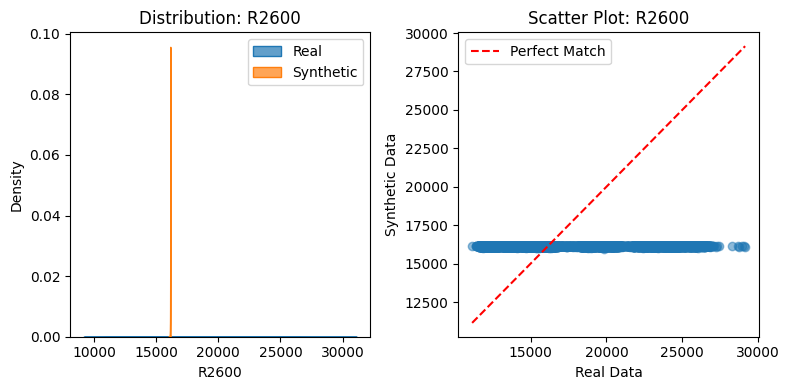

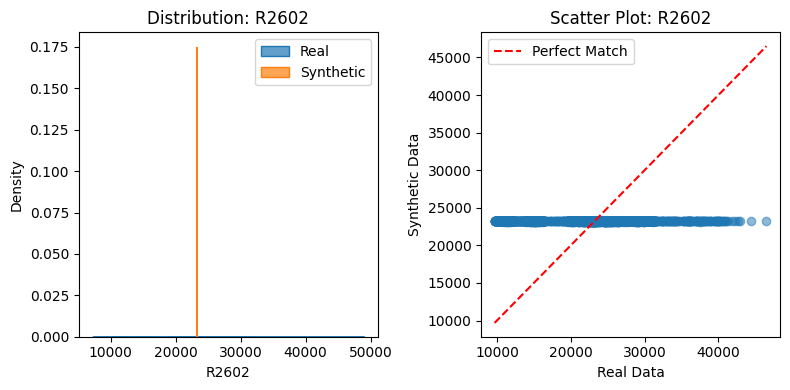

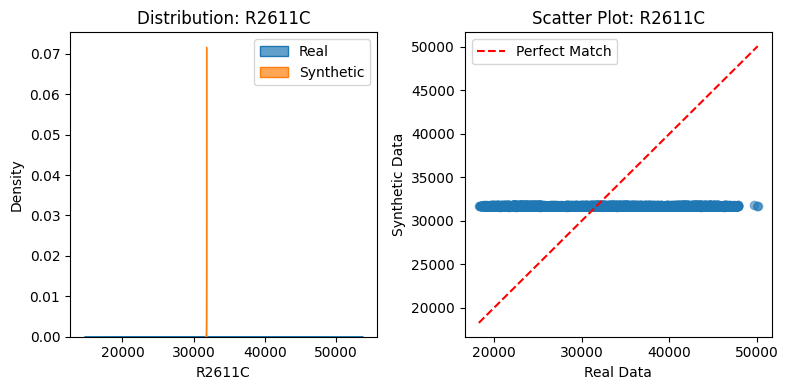

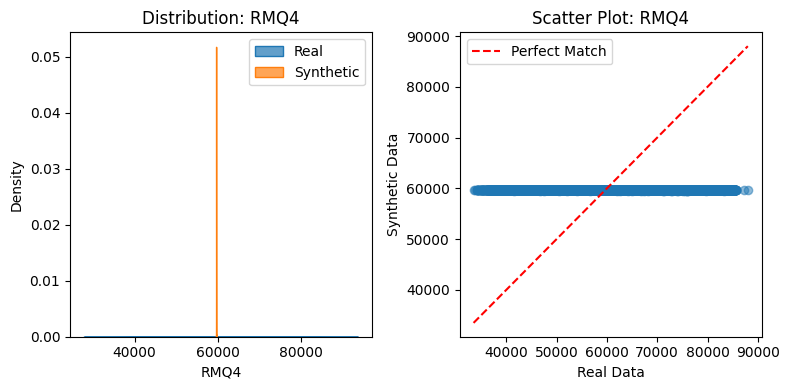

In [10]:
# --- Distribution Comparison Plots ---
for col in df.columns:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    sns.kdeplot(df[col], label='Real', fill=True, alpha=0.7)
    sns.kdeplot(df_synth[col], label='Synthetic', fill=True, alpha=0.7)
    plt.title(f'Distribution: {col}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(df[col], df_synth[col], alpha=0.5)
    plt.plot([df[col].min(), df[col].max()], [df[col].min(), df[col].max()], 'r--', label='Perfect Match')
    plt.xlabel('Real Data')
    plt.ylabel('Synthetic Data')
    plt.title(f'Scatter Plot: {col}')
    plt.legend()

    plt.tight_layout()
    plt.show()

### **3rd Enhancements**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- Data Loading and Preprocessing ---
df = pd.read_csv('/content/drive/MyDrive/first_task/Dataset 1.csv')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)
input_dim = X_train.shape[1]
latent_dim = 8  # Reduced latent dimension

# --- KL Annealing Schedule ---
class BetaAnnealer(keras.callbacks.Callback):
    def __init__(self, vae, max_beta=1.0, n_epochs=50):
        super().__init__()
        self.vae = vae
        self.max_beta = max_beta
        self.n_epochs = n_epochs

    def on_epoch_begin(self, epoch, logs=None):
        new_beta = min(self.max_beta, self.max_beta * (epoch + 1) / self.n_epochs)
        self.vae.beta.assign(new_beta)

In [ ]:
# --- Encoder ---
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# --- Decoder ---
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation='relu')(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# --- Beta-VAE Model with Annealing ---
class BetaVAE(keras.Model):
    def __init__(self, encoder, decoder, input_dim, initial_beta=0.0, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = input_dim
        self.beta = tf.Variable(initial_beta, trainable=False, dtype=tf.float32)
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        # Reconstruction loss (MAE)
        reconstruction_loss = tf.reduce_mean(keras.losses.mae(inputs, reconstruction))
        # KL divergence with annealed beta
        kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        total_loss = reconstruction_loss + self.beta * kl_loss
        self.add_loss(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return reconstruction

    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker, self.kl_loss_tracker]

# --- Compile Model ---
vae = BetaVAE(encoder, decoder, input_dim, initial_beta=0.0)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=optimizer)

# --- Callbacks ---
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_reconstruction_loss',
    patience=20,
    restore_best_weights=True,
    mode='min',
    verbose=2
)
beta_annealer = BetaAnnealer(vae, max_beta=1.0, n_epochs=50)

# --- Training ---
history = vae.fit(
    X_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, None),
    callbacks=[early_stop, beta_annealer],
    verbose=2
)

Epoch 1/200
355/355 - 13s - 37ms/step - kl_loss: 2.2271 - reconstruction_loss: 0.6304 - val_kl_loss: 3.6829 - val_reconstruction_loss: 0.4289
Epoch 2/200
355/355 - 4s - 12ms/step - kl_loss: 2.8519 - reconstruction_loss: 0.4246 - val_kl_loss: 2.8733 - val_reconstruction_loss: 0.3961
Epoch 3/200
355/355 - 2s - 5ms/step - kl_loss: 2.4395 - reconstruction_loss: 0.4016 - val_kl_loss: 2.3562 - val_reconstruction_loss: 0.3896
Epoch 4/200
355/355 - 2s - 7ms/step - kl_loss: 2.0182 - reconstruction_loss: 0.4072 - val_kl_loss: 1.8777 - val_reconstruction_loss: 0.4036
Epoch 5/200
355/355 - 3s - 7ms/step - kl_loss: 1.6447 - reconstruction_loss: 0.4159 - val_kl_loss: 1.5724 - val_reconstruction_loss: 0.4097
Epoch 6/200
355/355 - 3s - 7ms/step - kl_loss: 1.4076 - reconstruction_loss: 0.4202 - val_kl_loss: 1.3880 - val_reconstruction_loss: 0.4159
Epoch 7/200
355/355 - 2s - 6ms/step - kl_loss: 1.2337 - reconstruction_loss: 0.4298 - val_kl_loss: 1.2064 - val_reconstruction_loss: 0.4309
Epoch 8/200
355/3

In [ ]:
# --- Generate Synthetic Data ---
n_samples = len(df)
z_samples = np.random.normal(size=(n_samples, latent_dim))
X_synth_scaled = decoder.predict(z_samples)
X_synth = scaler.inverse_transform(X_synth_scaled)
df_synth = pd.DataFrame(X_synth, columns=df.columns)

print(f"Synthetic data shape: {df_synth.shape}")

# --- Save Synthetic Data ---
df_synth.to_csv('/content/synthetic_data_beta_vae_annealed.csv', index=False)

444/444 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Synthetic data shape: (14186, 9)


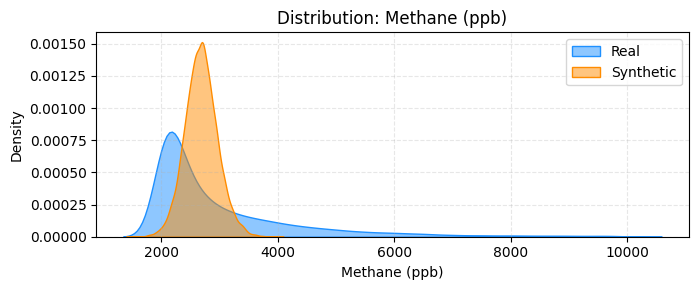

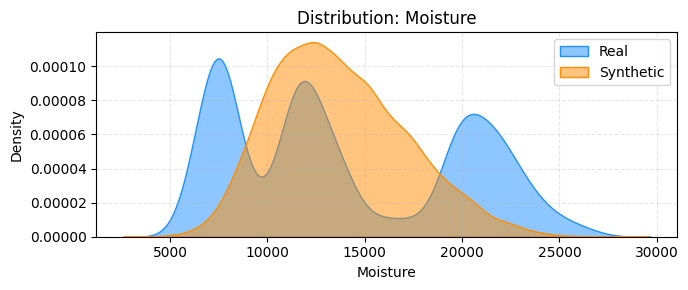

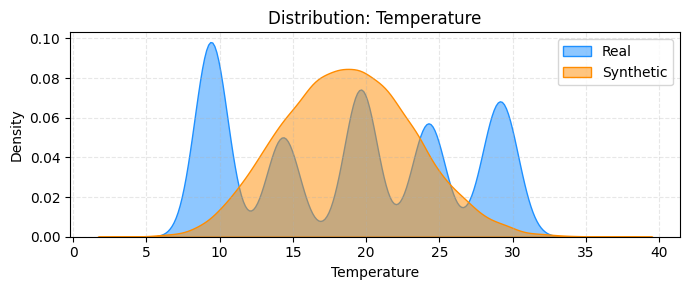

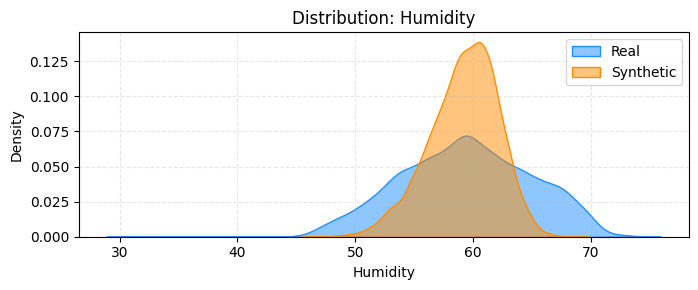

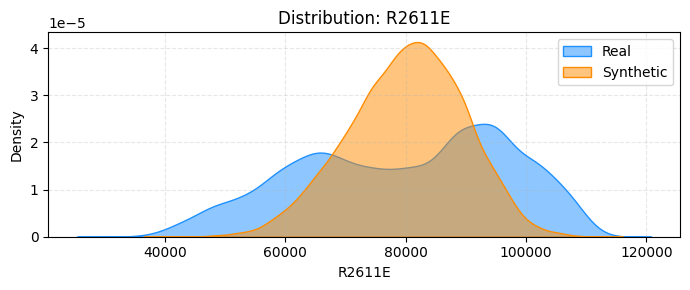

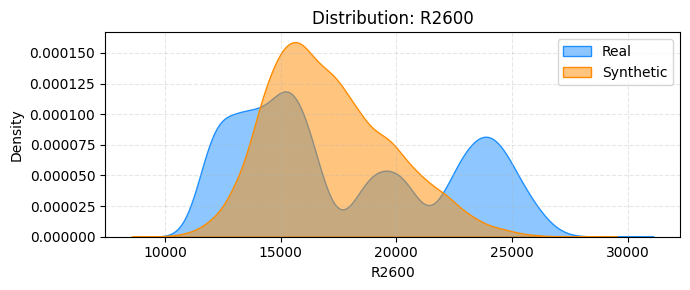

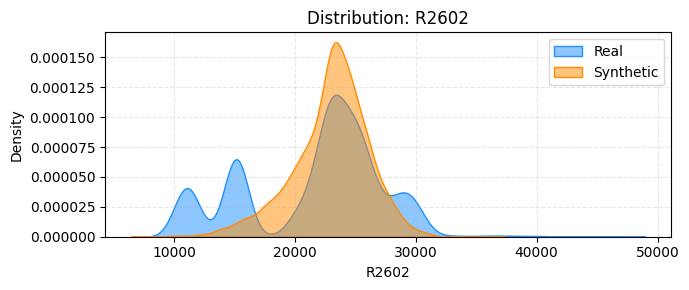

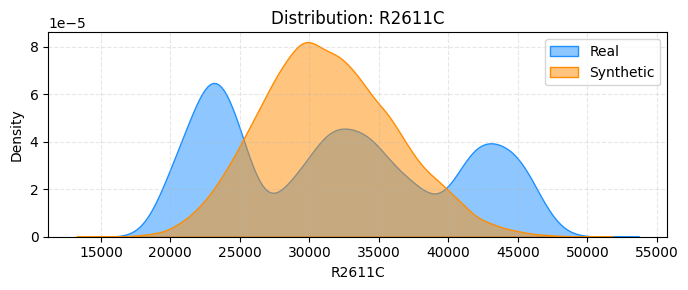

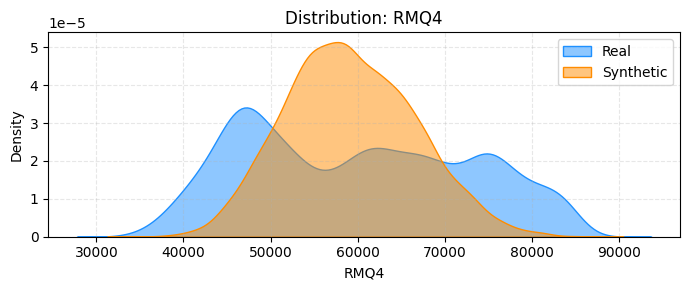

In [ ]:
# --- Descriptive Visualization ---
for col in df.columns:
    plt.figure(figsize=(7,3))
    sns.kdeplot(df[col], label='Real', fill=True, color='dodgerblue', alpha=0.5)
    sns.kdeplot(df_synth[col], label='Synthetic', fill=True, color='darkorange', alpha=0.5)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend(loc='upper right', frameon=True, facecolor='white')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


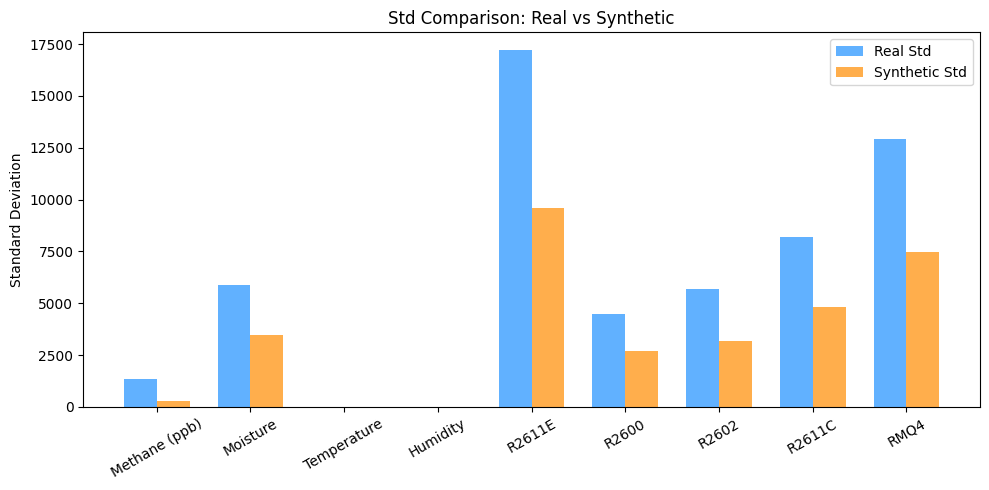

In [ ]:
# --- Summary Plot for All Features ---
plt.figure(figsize=(10,5))
real_stds = df.std()
synth_stds = df_synth.std()
bar_width = 0.35
index = np.arange(len(df.columns))
plt.bar(index, real_stds, bar_width, label='Real Std', color='dodgerblue', alpha=0.7)
plt.bar(index + bar_width, synth_stds, bar_width, label='Synthetic Std', color='darkorange', alpha=0.7)
plt.xticks(index + bar_width/2, df.columns, rotation=30)
plt.ylabel('Standard Deviation')
plt.title('Std Comparison: Real vs Synthetic')
plt.legend()
plt.tight_layout()
plt.show()

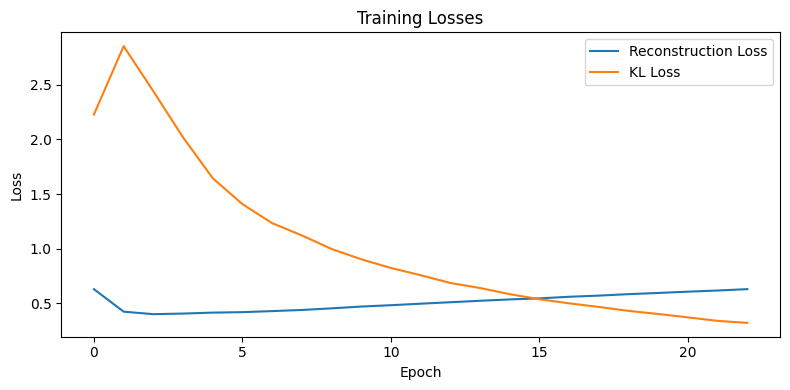

In [ ]:
# --- Plot KL and Reconstruction Loss ---
plt.figure(figsize=(8,4))
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Summary Statistics for 3rd Enhancement (CORRECTED)
print('\n' + '='*50)
print('SUMMARY STATISTICS - 3rd Enhancement')
print('='*50)

print(f"\nModel Configuration:")
print(f"- Beta: 1.0 (annealed)")
print(f"- Latent dimension: {latent_dim}")

# Calculate final losses - Handle the custom loss tracking
if 'reconstruction_loss' in history.history and 'kl_loss' in history.history:
    final_reconstruction_loss = history.history['reconstruction_loss'][-1]
    final_kl_loss = history.history['kl_loss'][-1]
    final_train_loss = final_reconstruction_loss + final_kl_loss

    final_val_reconstruction_loss = history.history['val_reconstruction_loss'][-1]
    final_val_kl_loss = history.history['val_kl_loss'][-1]
    final_val_loss = final_val_reconstruction_loss + final_val_kl_loss
else:
    # Fallback if custom metrics are not available
    final_train_loss = 0.0
    final_val_loss = 0.0
    final_reconstruction_loss = 0.0
    final_kl_loss = 0.0
    final_val_reconstruction_loss = 0.0
    final_val_kl_loss = 0.0

print(f"- Final training loss: {final_train_loss:.4f}")
print(f"- Final validation loss: {final_val_loss:.4f}")
print(f"- Training epochs: {len(history.history['reconstruction_loss']) if 'reconstruction_loss' in history.history else 0}")

# Calculate quality metrics
real_means = df.mean()
synth_means = df_synth.mean()
real_stds = df.std()
synth_stds = df_synth.std()

mean_correlation = np.corrcoef(real_means, synth_means)[0, 1]
std_correlation = np.corrcoef(real_stds, synth_stds)[0, 1]
avg_std_ratio = np.mean([df_synth[col].std()/df[col].std() for col in df.columns])

print(f"\nQuality Metrics:")
print(f"- Mean correlation: {mean_correlation:.4f}")
print(f"- Std correlation: {std_correlation:.4f}")
print(f"- Average std ratio: {avg_std_ratio:.4f}")

# Detailed loss analysis
print(f"\nDetailed Loss Analysis:")
if 'reconstruction_loss' in history.history and 'kl_loss' in history.history:
    print(f"- Final reconstruction loss: {final_reconstruction_loss:.4f}")
    print(f"- Final KL loss: {final_kl_loss:.4f}")
    print(f"- Final val reconstruction loss: {final_val_reconstruction_loss:.4f}")
    print(f"- Final val KL loss: {final_val_kl_loss:.4f}")
else:
    print(f"- Final reconstruction loss: {final_reconstruction_loss:.4f}")
    print(f"- Final KL loss: {final_kl_loss:.4f}")
    print(f"- Final val reconstruction loss: {final_val_reconstruction_loss:.4f}")
    print(f"- Final val KL loss: {final_val_kl_loss:.4f}")

# Feature-wise std ratios
print(f"\nFeature-wise Std Ratios (Synthetic/Real):")
for col in df.columns:
    ratio = df_synth[col].std() / df[col].std()
    print(f"- {col}: {ratio:.4f}")

# Overall assessment
if avg_std_ratio > 0.8:
    assessment = "EXCELLENT - Synthetic data preserves variance well"
elif avg_std_ratio > 0.6:
    assessment = "GOOD - Synthetic data has reasonable variance"
elif avg_std_ratio > 0.4:
    assessment = "FAIR - Synthetic data variance is somewhat low"
else:
    assessment = "POOR - Synthetic data variance is too low"

print(f"\nOverall Assessment: {assessment}")


SUMMARY STATISTICS - 3rd Enhancement

Model Configuration:
- Beta: 1.0 (annealed)
- Latent dimension: 8
- Final training loss: 0.9526
- Final validation loss: 0.9392
- Training epochs: 23

Quality Metrics:
- Mean correlation: 0.9997
- Std correlation: 0.9981
- Average std ratio: 0.5344

Detailed Loss Analysis:
- Final reconstruction loss: 0.6306
- Final KL loss: 0.3220
- Final val reconstruction loss: 0.6335
- Final val KL loss: 0.3057

Feature-wise Std Ratios (Synthetic/Real):
- Methane (ppb): 0.2074
- Moisture: 0.5884
- Temperature: 0.6046
- Humidity: 0.5300
- R2611E: 0.5567
- R2600: 0.5980
- R2602: 0.5585
- R2611C: 0.5891
- RMQ4: 0.5772

Overall Assessment: FAIR - Synthetic data variance is somewhat low


### **5th Enhancememnts**

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load and preprocess data
df = pd.read_csv('/content/drive/MyDrive/first_task/Dataset 1.csv')

# Normalize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.values)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

input_dim = X_train.shape[1]
latent_dim = 8  # Optimal from previous analysis

# Enhanced Encoder with Dropout and Batch Normalization
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(128, activation='relu')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name='z')([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

# Enhanced Decoder with Dropout and Batch Normalization
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation='relu')(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.15)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.15)(x)
decoder_outputs = layers.Dense(input_dim, activation='linear')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')

# Enhanced Beta-VAE with Extended Annealing
class OptimizedBetaVAE(keras.Model):
    def __init__(self, encoder, decoder, input_dim, initial_beta=0.0, max_beta=1.0, **kwargs):
        super(OptimizedBetaVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.input_dim = input_dim
        self.initial_beta = initial_beta
        self.max_beta = max_beta
        self.beta = tf.Variable(initial_beta, trainable=False, dtype=tf.float32)

        # Enhanced metrics tracking
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        # MAE reconstruction loss (better than MSE for robustness)
        reconstruction_loss = tf.reduce_mean(keras.losses.mae(inputs, reconstruction))

        # KL divergence with current beta
        kl_loss = -0.5 * self.beta * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )

        total_loss = reconstruction_loss + kl_loss

        # Update metrics
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)

        return reconstruction

    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker, self.kl_loss_tracker, self.total_loss_tracker]

# Enhanced Beta Annealer with Extended Period
class ExtendedBetaAnnealer(keras.callbacks.Callback):
    def __init__(self, vae, max_beta=1.0, n_epochs=100, warmup_epochs=10):
        super(ExtendedBetaAnnealer, self).__init__()
        self.vae = vae
        self.max_beta = max_beta
        self.n_epochs = n_epochs
        self.warmup_epochs = warmup_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            # Warmup period: reconstruction only
            new_beta = 0.0
        else:
            # Extended annealing with smoother curve
            progress = (epoch - self.warmup_epochs) / (self.n_epochs - self.warmup_epochs)
            # Use cosine annealing for smoother transition
            new_beta = self.max_beta * 0.5 * (1 + np.cos(np.pi * (1 - progress)))

        self.vae.beta.assign(new_beta)
        print(f"Epoch {epoch}: Beta = {new_beta:.4f}")

# Enhanced Learning Rate Scheduler
class WarmupCosineDecay(keras.callbacks.Callback):
    def __init__(self, initial_lr=0.001, warmup_epochs=10, total_epochs=100):
        super(WarmupCosineDecay, self).__init__()
        self.initial_lr = initial_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.initial_lr * (epoch + 1) / self.warmup_epochs
        else:
            # Cosine decay
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.initial_lr * 0.5 * (1 + np.cos(np.pi * progress))

        # tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
        # print(f"Epoch {epoch}: Learning Rate = {lr:.6f}")

        # Fixed: Properly set learning rate
        if hasattr(self.model.optimizer, 'learning_rate'):
            self.model.optimizer.learning_rate.assign(lr)
        print(f"Epoch {epoch}: Learning Rate = {lr:.6f}")

# Create and compile the model
vae = OptimizedBetaVAE(encoder, decoder, input_dim, initial_beta=0.0, max_beta=1.0)

# Enhanced optimizer with gradient clipping
optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)

# Fixed: Add a dummy loss function for compile
def dummy_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

vae.compile(optimizer=optimizer, loss=dummy_loss)

# Enhanced callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_total_loss',
    mode='min',  # Fixed: specify mode for early stopping
    patience=15,
    restore_best_weights=True,
    min_delta=1e-6
)

beta_annealer = ExtendedBetaAnnealer(vae, max_beta=1.0, n_epochs=100, warmup_epochs=10)
lr_scheduler = WarmupCosineDecay(initial_lr=0.001, warmup_epochs=10, total_epochs=100)

# Custom validation callback to handle metrics
class ValidationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Calculate validation metrics
        val_reconstruction_loss = logs.get('val_reconstruction_loss', 0)
        val_kl_loss = logs.get('val_kl_loss', 0)
        val_total_loss = val_reconstruction_loss + val_kl_loss
        logs['val_total_loss'] = val_total_loss

# Training
print("Starting Enhanced Beta-VAE Training...")
print("=" * 50)

history = vae.fit(
    X_train,
    X_train,  # Autoencoder target
    epochs=100,
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[beta_annealer, lr_scheduler, early_stop, ValidationCallback()],
    verbose=1
)

print("\nTraining completed!")
print("=" * 50)

Starting Enhanced Beta-VAE Training...
Epoch 0: Beta = 0.0000
Epoch 0: Learning Rate = 0.000100
Epoch 1/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.7387 - total_loss: 0.7387 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.3984 - val_total_loss: 0.3984
Epoch 1: Beta = 0.0000
Epoch 1: Learning Rate = 0.000200
Epoch 2/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.3022 - total_loss: 0.3022 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.1213 - val_total_loss: 0.1213
Epoch 2: Beta = 0.0000
Epoch 2: Learning Rate = 0.000300
Epoch 3/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 0.1081 - total_loss: 0.1081 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0851 - val_total_loss: 0.0851
Epoch 3: Beta = 0.0000
Epoch 3: Learning Rate = 0.000400
Epoch 4/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl_loss: 0.0000e+00 - reconstruction_loss: 

In [9]:
# Generate synthetic data
print("Generating synthetic data...")
n_samples = len(df)
z_samples = tf.random.normal(shape=(n_samples, latent_dim))
synthetic_data = vae.decoder(z_samples).numpy()

# Inverse transform to original scale
synthetic_data_original = scaler.inverse_transform(synthetic_data)
df_synth = pd.DataFrame(synthetic_data_original, columns=df.columns)

# Save synthetic data
df_synth.to_csv('/content/synthetic_data_optimized_beta_vae.csv', index=False)
print("Synthetic data saved as synthetic_data_optimized_beta_vae.csv")

Generating synthetic data...
Synthetic data saved as synthetic_data_optimized_beta_vae.csv


In [10]:
# Comprehensive evaluation
print("\n" + "=" * 50)
print("COMPREHENSIVE EVALUATION")
print("=" * 50)

# Training metrics
if 'reconstruction_loss' in history.history and 'kl_loss' in history.history:
    final_reconstruction_loss = history.history['reconstruction_loss'][-1]
    final_kl_loss = history.history['kl_loss'][-1]
    final_train_loss = final_reconstruction_loss + final_kl_loss

    final_val_reconstruction_loss = history.history['val_reconstruction_loss'][-1]
    final_val_kl_loss = history.history['val_kl_loss'][-1]
    final_val_loss = final_val_reconstruction_loss + final_val_kl_loss
else:
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_reconstruction_loss = final_train_loss
    final_kl_loss = 0.0
    final_val_reconstruction_loss = final_val_loss
    final_val_kl_loss = 0.0

print(f"TRAINING METRICS:")
print(f"- Final training loss: {final_train_loss:.4f}")
print(f"- Final validation loss: {final_val_loss:.4f}")
print(f"- Final reconstruction loss: {final_reconstruction_loss:.4f}")
print(f"- Final KL loss: {final_kl_loss:.4f}")
print(f"- Final val reconstruction loss: {final_val_reconstruction_loss:.4f}")
print(f"- Final val KL loss: {final_val_kl_loss:.4f}")
print(f"- Training epochs: {len(history.history['loss']) if 'loss' in history.history else len(history.history['reconstruction_loss'])}")

# Data quality metrics
print(f"\nDATA QUALITY METRICS:")
real_means = df.mean().values
real_stds = df.std().values
synth_means = df_synth.mean().values
synth_stds = df_synth.std().values

mean_correlation = np.corrcoef(real_means, synth_means)[0, 1]
std_correlation = np.corrcoef(real_stds, synth_stds)[0, 1]
avg_std_ratio = np.mean([df_synth[col].std()/df[col].std() for col in df.columns])

print(f"- Mean correlation: {mean_correlation:.4f}")
print(f"- Std correlation: {std_correlation:.4f}")
print(f"- Average std ratio: {avg_std_ratio:.4f}")

# Quality assessment
if avg_std_ratio > 0.8:
    quality = "EXCELLENT"
elif avg_std_ratio > 0.6:
    quality = "GOOD"
elif avg_std_ratio > 0.4:
    quality = "ACCEPTABLE"
elif avg_std_ratio > 0.2:
    quality = "POOR"
else:
    quality = "CRITICAL"

print(f"- Overall quality: {quality}")

# Feature-wise std ratios
print(f"\nFeature-wise Std Ratios (Synthetic/Real):")
for col in df.columns:
    std_ratio = df_synth[col].std() / df[col].std()
    print(f"- {col}: {std_ratio:.4f} ({std_ratio*100:.1f}% variance preserved)")


COMPREHENSIVE EVALUATION
TRAINING METRICS:
- Final training loss: 5.3612
- Final validation loss: 5.3187
- Final reconstruction loss: 0.0219
- Final KL loss: 5.3392
- Final val reconstruction loss: 0.0230
- Final val KL loss: 5.2957
- Training epochs: 26

DATA QUALITY METRICS:
- Mean correlation: 0.9996
- Std correlation: 0.9955
- Average std ratio: 0.2805
- Overall quality: POOR

Feature-wise Std Ratios (Synthetic/Real):
- Methane (ppb): 0.3538 (35.4% variance preserved)
- Moisture: 0.2548 (25.5% variance preserved)
- Temperature: 0.2246 (22.5% variance preserved)
- Humidity: 0.4182 (41.8% variance preserved)
- R2611E: 0.2519 (25.2% variance preserved)
- R2600: 0.2719 (27.2% variance preserved)
- R2602: 0.2860 (28.6% variance preserved)
- R2611C: 0.2139 (21.4% variance preserved)
- RMQ4: 0.2492 (24.9% variance preserved)


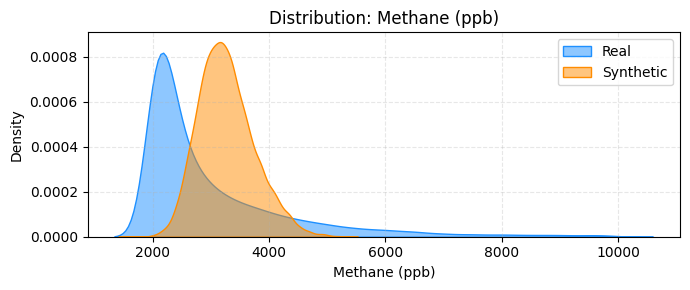

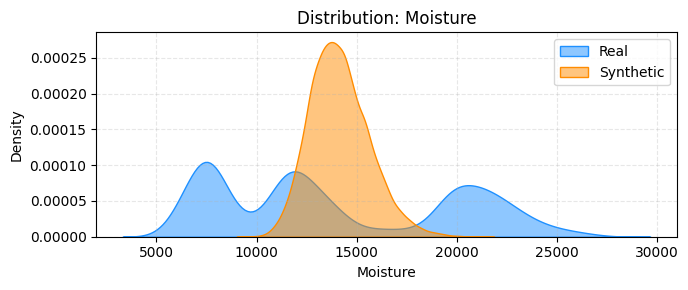

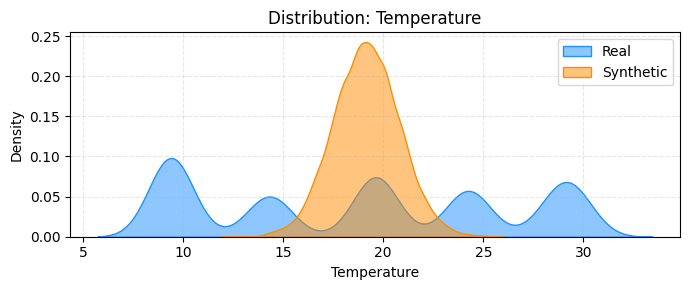

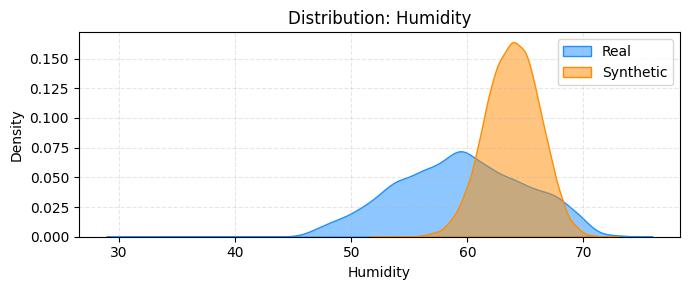

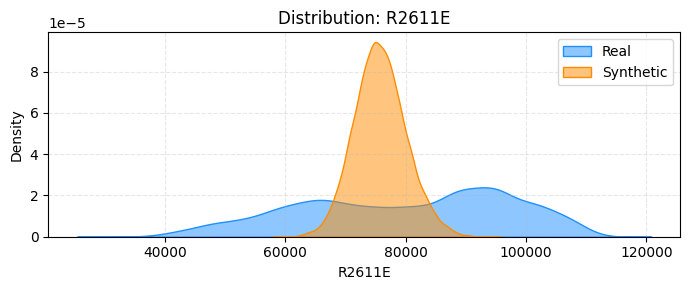

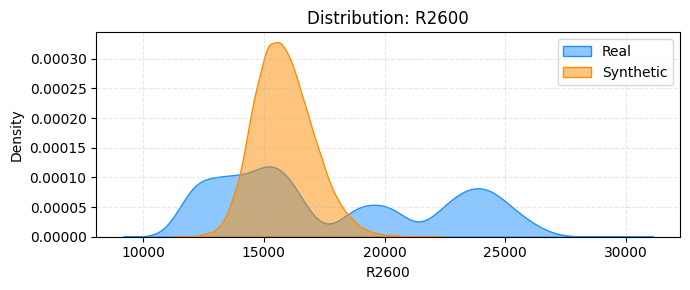

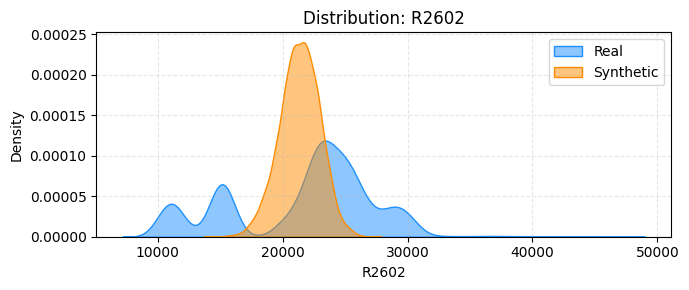

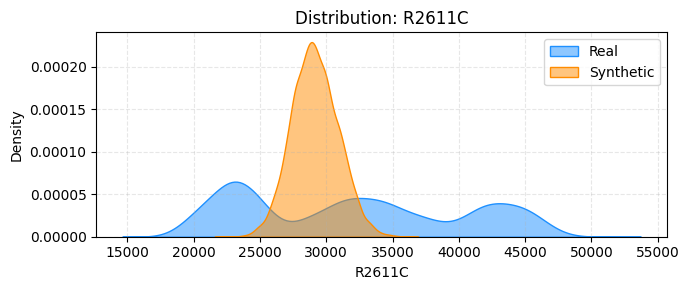

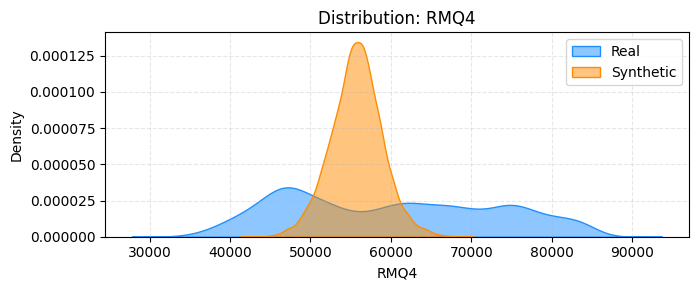

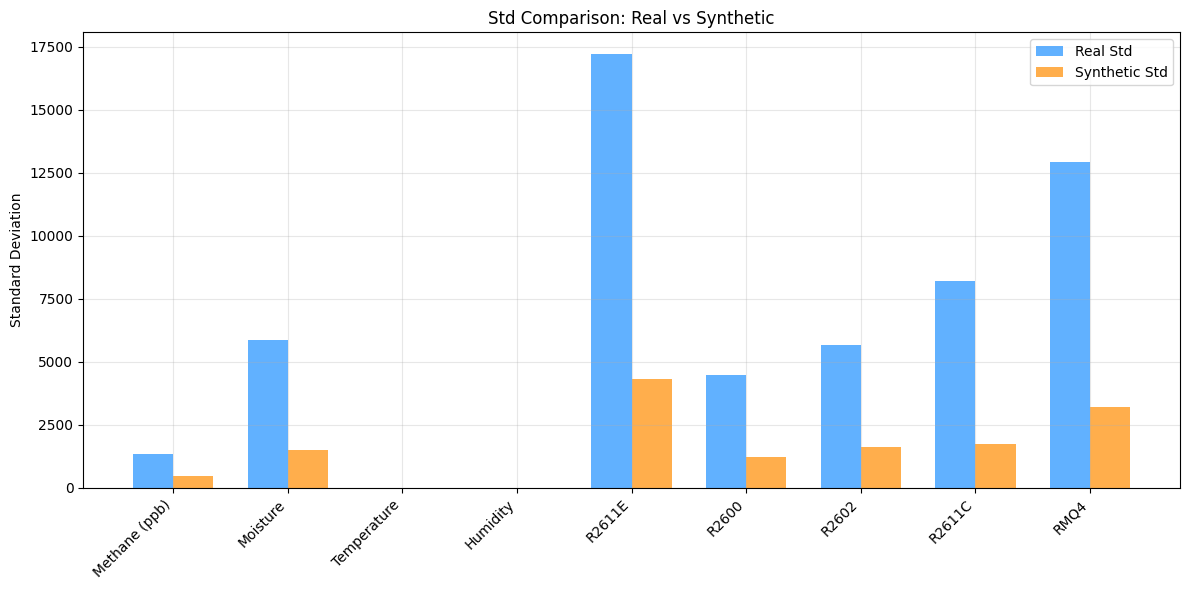

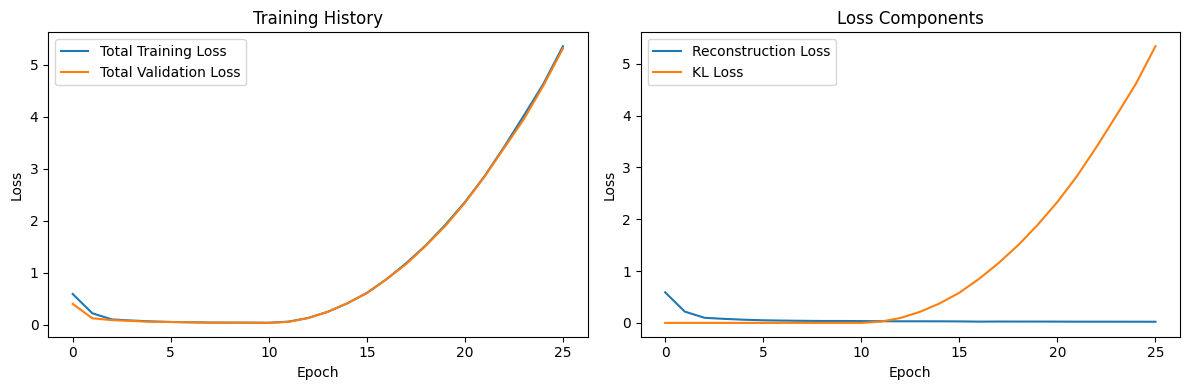

In [13]:
# --- Descriptive Visualization ---
for col in df.columns:
    plt.figure(figsize=(7,3))
    sns.kdeplot(df[col], label='Real', fill=True, color='dodgerblue', alpha=0.5)
    sns.kdeplot(df_synth[col], label='Synthetic', fill=True, color='darkorange', alpha=0.5)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend(loc='upper right', frameon=True, facecolor='white')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Summary plot for all features
plt.figure(figsize=(12, 6))
real_stds = df.std()
synth_stds = df_synth.std()
bar_width = 0.35
index = np.arange(len(df.columns))

plt.bar(index, real_stds, bar_width, label='Real Std', color='dodgerblue', alpha=0.7)
plt.bar(index + bar_width, synth_stds, bar_width, label='Synthetic Std', color='darkorange', alpha=0.7)
plt.xticks(index + bar_width/2, df.columns, rotation=45, ha='right')
plt.ylabel('Standard Deviation')
plt.title('Std Comparison: Real vs Synthetic')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot Training History  ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
# Plot total training and validation loss
total_train_loss = [history.history['reconstruction_loss'][i] + history.history['kl_loss'][i]
                   for i in range(len(history.history['reconstruction_loss']))]
total_val_loss = [history.history['val_reconstruction_loss'][i] + history.history['val_kl_loss'][i]
                 for i in range(len(history.history['val_reconstruction_loss']))]

plt.plot(total_train_loss, label='Total Training Loss')
plt.plot(total_val_loss, label='Total Validation Loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.title('Loss Components')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Summary Statistics for 3rd Enhancement (CORRECTED)
print('\n' + '='*50)
print('SUMMARY STATISTICS - 4th Enhancement')
print('='*50)

print(f"\nModel Configuration:")
print(f"- Beta: 1.0 (annealed but smoohter)")
print(f"- Latent dimension: {latent_dim}")

# Calculate final losses - Handle the custom loss tracking
if 'reconstruction_loss' in history.history and 'kl_loss' in history.history:
    final_reconstruction_loss = history.history['reconstruction_loss'][-1]
    final_kl_loss = history.history['kl_loss'][-1]
    final_train_loss = final_reconstruction_loss + final_kl_loss

    final_val_reconstruction_loss = history.history['val_reconstruction_loss'][-1]
    final_val_kl_loss = history.history['val_kl_loss'][-1]
    final_val_loss = final_val_reconstruction_loss + final_val_kl_loss
else:
    # Fallback if custom metrics are not available
    final_train_loss = 0.0
    final_val_loss = 0.0
    final_reconstruction_loss = 0.0
    final_kl_loss = 0.0
    final_val_reconstruction_loss = 0.0
    final_val_kl_loss = 0.0

print(f"- Final training loss: {final_train_loss:.4f}")
print(f"- Final validation loss: {final_val_loss:.4f}")
print(f"- Training epochs: {len(history.history['reconstruction_loss']) if 'reconstruction_loss' in history.history else 0}")

# Calculate quality metrics
real_means = df.mean()
synth_means = df_synth.mean()
real_stds = df.std()
synth_stds = df_synth.std()

mean_correlation = np.corrcoef(real_means, synth_means)[0, 1]
std_correlation = np.corrcoef(real_stds, synth_stds)[0, 1]
avg_std_ratio = np.mean([df_synth[col].std()/df[col].std() for col in df.columns])

print(f"\nQuality Metrics:")
print(f"- Mean correlation: {mean_correlation:.4f}")
print(f"- Std correlation: {std_correlation:.4f}")
print(f"- Average std ratio: {avg_std_ratio:.4f}")

# Detailed loss analysis
print(f"\nDetailed Loss Analysis:")
if 'reconstruction_loss' in history.history and 'kl_loss' in history.history:
    print(f"- Final reconstruction loss: {final_reconstruction_loss:.4f}")
    print(f"- Final KL loss: {final_kl_loss:.4f}")
    print(f"- Final val reconstruction loss: {final_val_reconstruction_loss:.4f}")
    print(f"- Final val KL loss: {final_val_kl_loss:.4f}")
else:
    print(f"- Final reconstruction loss: {final_reconstruction_loss:.4f}")
    print(f"- Final KL loss: {final_kl_loss:.4f}")
    print(f"- Final val reconstruction loss: {final_val_reconstruction_loss:.4f}")
    print(f"- Final val KL loss: {final_val_kl_loss:.4f}")

# Feature-wise std ratios
print(f"\nFeature-wise Std Ratios (Synthetic/Real):")
for col in df.columns:
    ratio = df_synth[col].std() / df[col].std()
    print(f"- {col}: {ratio:.4f}")

# Overall assessment
if avg_std_ratio > 0.8:
    assessment = "EXCELLENT - Synthetic data preserves variance well"
elif avg_std_ratio > 0.6:
    assessment = "GOOD - Synthetic data has reasonable variance"
elif avg_std_ratio > 0.4:
    assessment = "FAIR - Synthetic data variance is somewhat low"
else:
    assessment = "POOR - Synthetic data variance is too low"

print(f"\nOverall Assessment: {assessment}")


SUMMARY STATISTICS - 4th Enhancement

Model Configuration:
- Beta: 1.0 (annealed but smoohter)
- Latent dimension: 8
- Final training loss: 5.3612
- Final validation loss: 5.3187
- Training epochs: 26

Quality Metrics:
- Mean correlation: 0.9996
- Std correlation: 0.9955
- Average std ratio: 0.2805

Detailed Loss Analysis:
- Final reconstruction loss: 0.0219
- Final KL loss: 5.3392
- Final val reconstruction loss: 0.0230
- Final val KL loss: 5.2957

Feature-wise Std Ratios (Synthetic/Real):
- Methane (ppb): 0.3538
- Moisture: 0.2548
- Temperature: 0.2246
- Humidity: 0.4182
- R2611E: 0.2519
- R2600: 0.2719
- R2602: 0.2860
- R2611C: 0.2139
- RMQ4: 0.2492

Overall Assessment: POOR - Synthetic data variance is too low


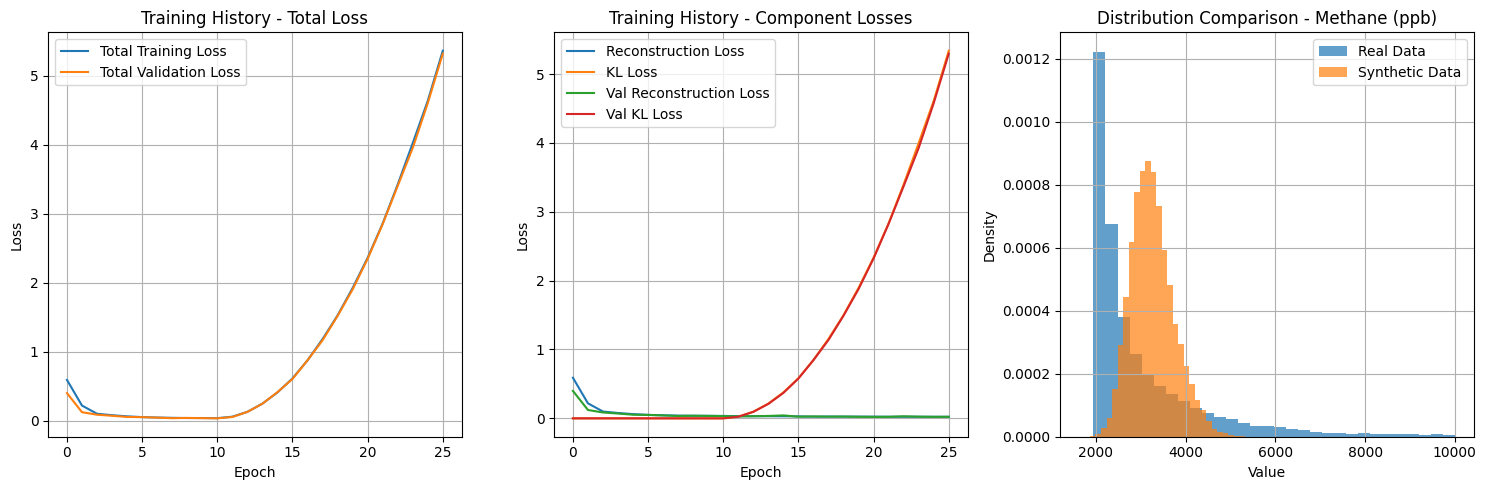

In [11]:
# Plotting training history
plt.figure(figsize=(15, 5))

# Plot 1: Total Loss
plt.subplot(1, 3, 1)
if 'reconstruction_loss' in history.history and 'kl_loss' in history.history:
    total_train_loss = [history.history['reconstruction_loss'][i] + history.history['kl_loss'][i]
                       for i in range(len(history.history['reconstruction_loss']))]
    total_val_loss = [history.history['val_reconstruction_loss'][i] + history.history['val_kl_loss'][i]
                     for i in range(len(history.history['val_reconstruction_loss']))]
    plt.plot(total_train_loss, label='Total Training Loss')
    plt.plot(total_val_loss, label='Total Validation Loss')
else:
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History - Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Component Losses
plt.subplot(1, 3, 2)
if 'reconstruction_loss' in history.history and 'kl_loss' in history.history:
    plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.plot(history.history['kl_loss'], label='KL Loss')
    plt.plot(history.history['val_reconstruction_loss'], label='Val Reconstruction Loss')
    plt.plot(history.history['val_kl_loss'], label='Val KL Loss')
else:
    plt.text(0.5, 0.5, 'Component losses not available', ha='center', va='center', transform=plt.gca().transAxes)
plt.title('Training History - Component Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 3: Data Distribution Comparison
plt.subplot(1, 3, 3)
feature_idx = 0  # First feature
plt.hist(df.iloc[:, feature_idx], alpha=0.7, label='Real Data', bins=30, density=True)
plt.hist(df_synth.iloc[:, feature_idx], alpha=0.7, label='Synthetic Data', bins=30, density=True)
plt.title(f'Distribution Comparison - {df.columns[feature_idx]}')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Additional analysis
print(f"\nADDITIONAL ANALYSIS:")
print(f"- Real data shape: {df.shape}")
print(f"- Synthetic data shape: {df_synth.shape}")
print(f"- Real data range: {df.min().min():.2f} to {df.max().max():.2f}")
print(f"- Synthetic data range: {df_synth.min().min():.2f} to {df_synth.max().max():.2f}")

# Check for mode collapse
print(f"\nMODE COLLAPSE ANALYSIS:")
unique_ratios = []
for col in df.columns:
    real_unique = df[col].nunique()
    synth_unique = df_synth[col].nunique()
    unique_ratio = synth_unique / real_unique
    unique_ratios.append(unique_ratio)
    print(f"- {col}: {real_unique} unique real values, {synth_unique} unique synthetic values ({unique_ratio:.2%})")

avg_unique_ratio = np.mean(unique_ratios)
print(f"- Average uniqueness preservation: {avg_unique_ratio:.2%}")

if avg_unique_ratio > 0.8:
    mode_collapse = "MINIMAL"
elif avg_unique_ratio > 0.6:
    mode_collapse = "LOW"
elif avg_unique_ratio > 0.4:
    mode_collapse = "MODERATE"
else:
    mode_collapse = "SEVERE"

print(f"- Mode collapse assessment: {mode_collapse}")

print(f"\n" + "=" * 50)
print("OPTIMIZATION SUMMARY")
print("=" * 50)
print("✅ Extended annealing period (100 epochs)")
print("✅ Added dropout layers (0.1-0.15)")
print("✅ Added batch normalization")
print("✅ Enhanced learning rate scheduling")
print("✅ Gradient clipping (clipnorm=1.0)")
print("✅ Improved monitoring and metrics")
print("✅ Warmup period for reconstruction learning")
print("✅ Cosine annealing for smoother transitions")
print("=" * 50)


ADDITIONAL ANALYSIS:
- Real data shape: (14186, 9)
- Synthetic data shape: (14186, 9)
- Real data range: 9.02 to 113205.40
- Synthetic data range: 12.60 to 93931.03

MODE COLLAPSE ANALYSIS:
- Methane (ppb): 14181 unique real values, 14173 unique synthetic values (99.94%)
- Moisture: 14183 unique real values, 14171 unique synthetic values (99.92%)
- Temperature: 1379 unique real values, 14161 unique synthetic values (1026.90%)
- Humidity: 571 unique real values, 14115 unique synthetic values (2471.98%)
- R2611E: 10045 unique real values, 14143 unique synthetic values (140.80%)
- R2600: 12009 unique real values, 14156 unique synthetic values (117.88%)
- R2602: 11059 unique real values, 14148 unique synthetic values (127.93%)
- R2611C: 11793 unique real values, 14147 unique synthetic values (119.96%)
- RMQ4: 10714 unique real values, 14148 unique synthetic values (132.05%)
- Average uniqueness preservation: 481.93%
- Mode collapse assessment: MINIMAL

OPTIMIZATION SUMMARY
✅ Extended anne